In [4]:
options(warn=-1)
library(cowplot);library(ggpubr)
#library(patchwork)

library(dplyr);library(tidyverse)
library(data.table);library(Matrix)
library(magrittr)

library(viridis);library(tibble)
library(scales)
library(ggrepel);library(forcats)

library(Seurat);library(SingleCellExperiment)
library(parallel)
memory.limit(size = 98226*1024)
library(indRop)
library(scDblFinder)
# Pass TRUE if you want to see progress output on some of Monocle 3's operations
DelayedArray:::set_verbose_block_processing(TRUE)

# Passing a higher value will make some computations faster but use more memory. Adjust with caution!
options(DelayedArray.block.size=1000e6)

base::gc()
base::rm(list = ls()) # Clear the environment
GSE118918.marker <- c(
"Pdgfra","Vcan","Olig1","Ptprz1","Olig2", # opc
"Plp1","Cldn11","Cnp","Tspan2","Mobp", 
"Trf","Apod","Ermn","Car2",
"Ptgds","Plp1","Mal","Cryab","Car2", # 
"Fyn","Sirt2","Tuba1a","Bcas1","Enpp6", # cop
"Hexb","Ctss","C1qb","C1qc","Cx3cr1", # micro
"Lyz2","Mrc1","Pf4","Ctsb","F13a1", # macrophage
"Ly6c1","Ly6a","Flt1","Itm2a","Slco1a4", # Endothelial
"Rgs5","Acta2","Myl9","Tagln","Cald1", # Mural
"Dcn","Col1a2","Igf2","Igfbp2","Pcolce",#VLMC
"Ccdc153","Rarres2","Tmem212","Nnat","Rsph1", # Ependyma    
"Cpe","Apoe","Cst3","Mt1","Dbi","Aldoc","Gja1","Slc1a2","Slc1a3","Clu", 
"Ccnd2","Tubb5","Dlx1","Tmsb10","Tuba1a", #NSC
"Hmgb2","Top2a","Hmgn2","Tubb5","H2afz", # NSC    
"Sst","Npy","Resp18","Nap1l5","Nos1", # NEURON
"Lypd1","Meg3","Atp1b1","Snhg11","Olfm1",# NEURON
"Penk","Arpp21","Ppp3ca","Atp2b1","Hpca" #NEURON
)

oligo.mark <- c("Sirt2","Bmp4","Tnr","Fyn", "Enpp6", "Neu4",  # COP 
                  "C1ql1", "Olig1", "Pdgfra", "Cspg4",# OPC
                  "Apod", "Trf", "Plp1", "Mbp", "Fth1","Mag", "Mog","Cldn11","Mobp", # MOL
                  "Tmeff2","Idh1","Neu4", "Cdh20", "Tmem163", "Nfasc", "Mpzl1", # NFOL
                  "Mal","Opalin", "Ptgds","Bfsp2" #MFOL
                 )

setwd('~/R')
source('~/R/single_cell_function_20220408.R')

library(readxl)

sheet1 <- c("NSC","NPC", "OPC", "COP", "MFOL", 
           "MICRO", "CD45", "PERICYTE", "INTERNEURON")
gene1 <- GSE106447.MARKER.ALL <- list()
for(i in seq(1:9)){
    temp1 <-  read_excel(paste0(file.path("/home","choelab","working","public_dataset","GSE106447"),"/GSE106447.xlsx"), col_names=T, sheet = i)
    gene1[[i]] <- temp1$`GENE ID`[1:5]
    GSE106447.MARKER.ALL[[i]] <-  temp1$`GENE ID`
}    
GSE106447.MARKER <- unique(unlist(gene1))
names(GSE106447.MARKER.ALL) <- sheet1

# SMCs, smooth muscle cells; PVMs, perivascular macrophages; MSNs, medium spiny neurons,
sheet <- c("Endothelial_Cells","Pericyte", "SMC", "Microglia", "PVM", 
           "Ependymal", "MSN1", "MSN2", "COP", "MOL",
           "MFOL2", "MFOL1", "Neuroblast", "TAP", "OPC", 
           "Astrocyte", "NSC")
gene <- GSE111527.MARKER.ALL <- list()
for(i in seq(1:17)){
    temp <-  read_excel(paste0(file.path("/home","choelab","working","public_dataset","GSE111527"),"/GSE111527MARKER.xlsx"), col_names=T, sheet = i)
    gene[[i]] <- temp$gene[1:5]
    GSE111527.MARKER.ALL[[i]] <- temp$gene
}    
GSE111527.MARKER <- unique(unlist(gene))
names(GSE111527.MARKER.ALL) <- sheet


Loading required package: ggplot2


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching 

[1] Inf

[1] FALSE

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells  10449985  558.1   20535804 1096.8  14684388  784.3
Vcells 716777889 5468.6 1190471141 9082.6 724218205 5525.4

Loading required package: httr


Attaching package: ‘httr’


The following object is masked from ‘package:Biobase’:

    content


Loading required package: nichenetr



In [4]:
pathIMZ <- file.path("/home","choelab","working","OL_sorted","reference","GSE160512","raw")
fileListCNTs <- list.files(pathIMZ, pattern = ".txt.gz")
# fileListCNTs <- list.files(pathIMZ, pattern = "GSE180041_exonic_norm_umi.csv.gz")
path_in_counts.raw <- paste0(pathIMZ,"/",fileListCNTs)
# raw <- read.table(path_in_counts.raw, header =T, sep=",")
names(fileListCNTs) <- path_in_counts.raw

In [5]:

GSE160512.meta <- read.table("/home/choelab/working/OL_sorted/reference/GSE160512/GSE160512_PS2APPTsneCoordinatesAndClusterAssignments.txt.gz", header =T, sep="\t")
GSE160512.meta <- GSE160512.meta %>% tibble::column_to_rownames('cellID')



In [6]:

require(biomaRt)
annot <- c()
GSE160512.obj <- list()

ensembl <- useMart('ensembl', dataset = 'mmusculus_gene_ensembl')
for(x in path_in_counts.raw){
    temp <- readIndrop(x)
    annot <- getBM(attributes = c('mgi_symbol','ensembl_gene_id'),filters = 'ensembl_gene_id',values = colnames(temp),mart = ensembl)
    annot <- annot[-c(which((annot$mgi_symbol == '') | duplicated(annot$mgi_symbol) | duplicated(annot$ensembl_gene_id))),]
    temp <- temp[,annot$ensembl_gene_id]
    colnames(temp) <- gsub("-","\\.", annot$mgi_symbol)
    GSE160512.obj[[fileListCNTs[x]]] <- CreateSeuratObject(counts = t(temp), min.cells = 0)               
}



Loading required package: biomaRt

Ensembl site unresponsive, trying useast mirror

Ensembl site unresponsive, trying uswest mirror



In [7]:

GSE160512.obj.OL <- list()
GSE160512.obj.OL2 <- list()
GSE160512.obj.OL3 <- list()
GSE160512.obj.OL.wt <- list()
GSE160512.obj.OL.wt2 <- list()

for(x in path_in_counts.raw){
    y <- fileListCNTs[x]
    GSE160512.obj[[y]]$id <- fileListCNTs[x]
    GSE160512.obj[[y]]$basic <- "GSE160512"
    GSE160512.obj[[y]]$percent.mt <- PercentageFeatureSet(GSE160512.obj[[y]], pattern = paste0(c(mt.genes,"^mt."), collapse = "|"))
    GSE160512.obj[[y]]$percent.hb <- PercentageFeatureSet(GSE160512.obj[[y]], pattern = paste0(c('Hbq1a','Hbb.y','Hbb.bh1','Hbb.bs','Hba.x','Hba.a2','Hba.a1','Hbq1b','Hbb.bt','Hbb.bh2','Hbb.bh3','Hba.ps4','Hbb.bh0'), collapse = "|"))

    GSE160512.obj[[y]]$GSE160512.celltype <- GSE160512.meta[colnames(GSE160512.obj[[y]]),]$allCells.cluster.interpretation
    GSE160512.obj[[y]]$GSE160512.genotype <- GSE160512.meta[colnames(GSE160512.obj[[y]]),]$genotype
#     if(names(table(GSE160512.obj[[y]]$GSE160512.genotype)) == "Non-Tg"){
#         GSE160512.obj.OL.wt[[y]] <- GSE160512.obj[[y]][, grepl("^oligo|^OPC|^COP", GSE160512.obj[[y]]$GSE160512.celltype)]
#         GSE160512.obj.OL.wt2[[y]] <- GSE160512.obj[[y]][, grepl("^oligo|^COP", GSE160512.obj[[y]]$GSE160512.celltype)]

#     }
    

    GSE160512.obj.OL[[y]] <- GSE160512.obj[[y]][, grep("^oligo|^OPC|^COP", GSE160512.obj[[y]]$GSE160512.celltype)]
    # GSE160512.obj.OL2[[y]] <- GSE160512.obj[[y]][, grep("^oligo|^COP", GSE160512.obj[[y]]$GSE160512.celltype)]
    # GSE160512.obj.OL3[[y]] <- merge(GSE160512.obj.OL2[[y]], GSE160512.obj.OL[[y]][,GSE160512.obj.OL[[y]]$GSE160512.celltype == "OPC"][,1:200])
}

In [8]:
# PROCESS 1
GSE160512.merge <- merge(GSE160512.obj[[1]], y= c(GSE160512.obj[2:length(GSE160512.obj)]), project = 'merged',merge.data=T)

GSE160512.merge <- GSE160512.merge %>%
                  SCTransform(assay = 'RNA',      
                              new.assay.name = 'SCT',  
                              vars.to.regress = c("percent.mt","percent.hb","nFeature_RNA"),
                              verbose = T)   # normalize data with SCTransform()

GSE160512.merge <- FindVariableFeatures(GSE160512.merge, assay = "SCT",   nfeatures = 2000)

pcs <- 1:30
set.seed(1234)
library(harmony)
DefaultAssay(GSE160512.merge) <- "SCT"

GSE160512.merge <- GSE160512.merge %>%
                          RunPCA(verbose = FALSE, assay = "SCT", features = VariableFeatures(GSE160512.merge) ) %>%
                          RunHarmony(group.by=c("id"), assay.use = "SCT", dims=pcs) %>% 
                          RunUMAP(reduction = "harmony", umap.method = "umap-learn", assay = "SCT",  dims=pcs) %>%
                          FindNeighbors(reduction = "harmony", dims=pcs, assay = "SCT") %>%
                          FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 30381 by 47374

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 150 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 30381 genes



  |======================================================================| 100%


Computing corrected count matrix for 30381 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.384365 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, percent.hb, nFeature_RNA

Centering data matrix

Set default assay to SCT

Loading required package: Rcpp

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony converged after 8 iterations

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 47374
Number of edges: 1725215

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9706
Number of communities: 17
Elapsed time: 12 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 47374
Number of edges: 1725215

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9502
Number of communities: 19
Elapsed time: 14 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 47374
Number of edges: 1725215

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9368
Number of communities: 21
Elapsed time: 14 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 47374
Number of edges: 1725215

Running Louvain algorithm with multilevel refineme

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5)
ElbowPlot(GSE160512.merge, ndims=50)
pct <- GSE160512.merge[["pca"]]@stdev / sum(GSE160512.merge[["pca"]]@stdev) * 100
cumu <- cumsum(pct)
co1 <- which(cumu > 90 & pct < 5)[1]
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.1), decreasing = T)[1] + 1
pcs <- min(co1, co2)
pcs

In [5]:
# saveRDS(GSE153895.merge, paste0(file.path("/home","choelab","working","OL_sorted","reference"),"/GSE153895.merge.rds"))
# saveRDS(GSE160512.merge, paste0(file.path("/home","choelab","working","OL_sorted","reference"),"/GSE160512.merge.rds"))
# saveRDS(GSE160512.merge.oligo, paste0(file.path("/home","choelab","working","OL_sorted","reference"),"/GSE160512.merge.oligo.rds"))
GSE160512.merge <- readRDS(paste0(file.path("/home","choelab","working","OL_sorted","reference"),"/GSE160512.merge.rds"))

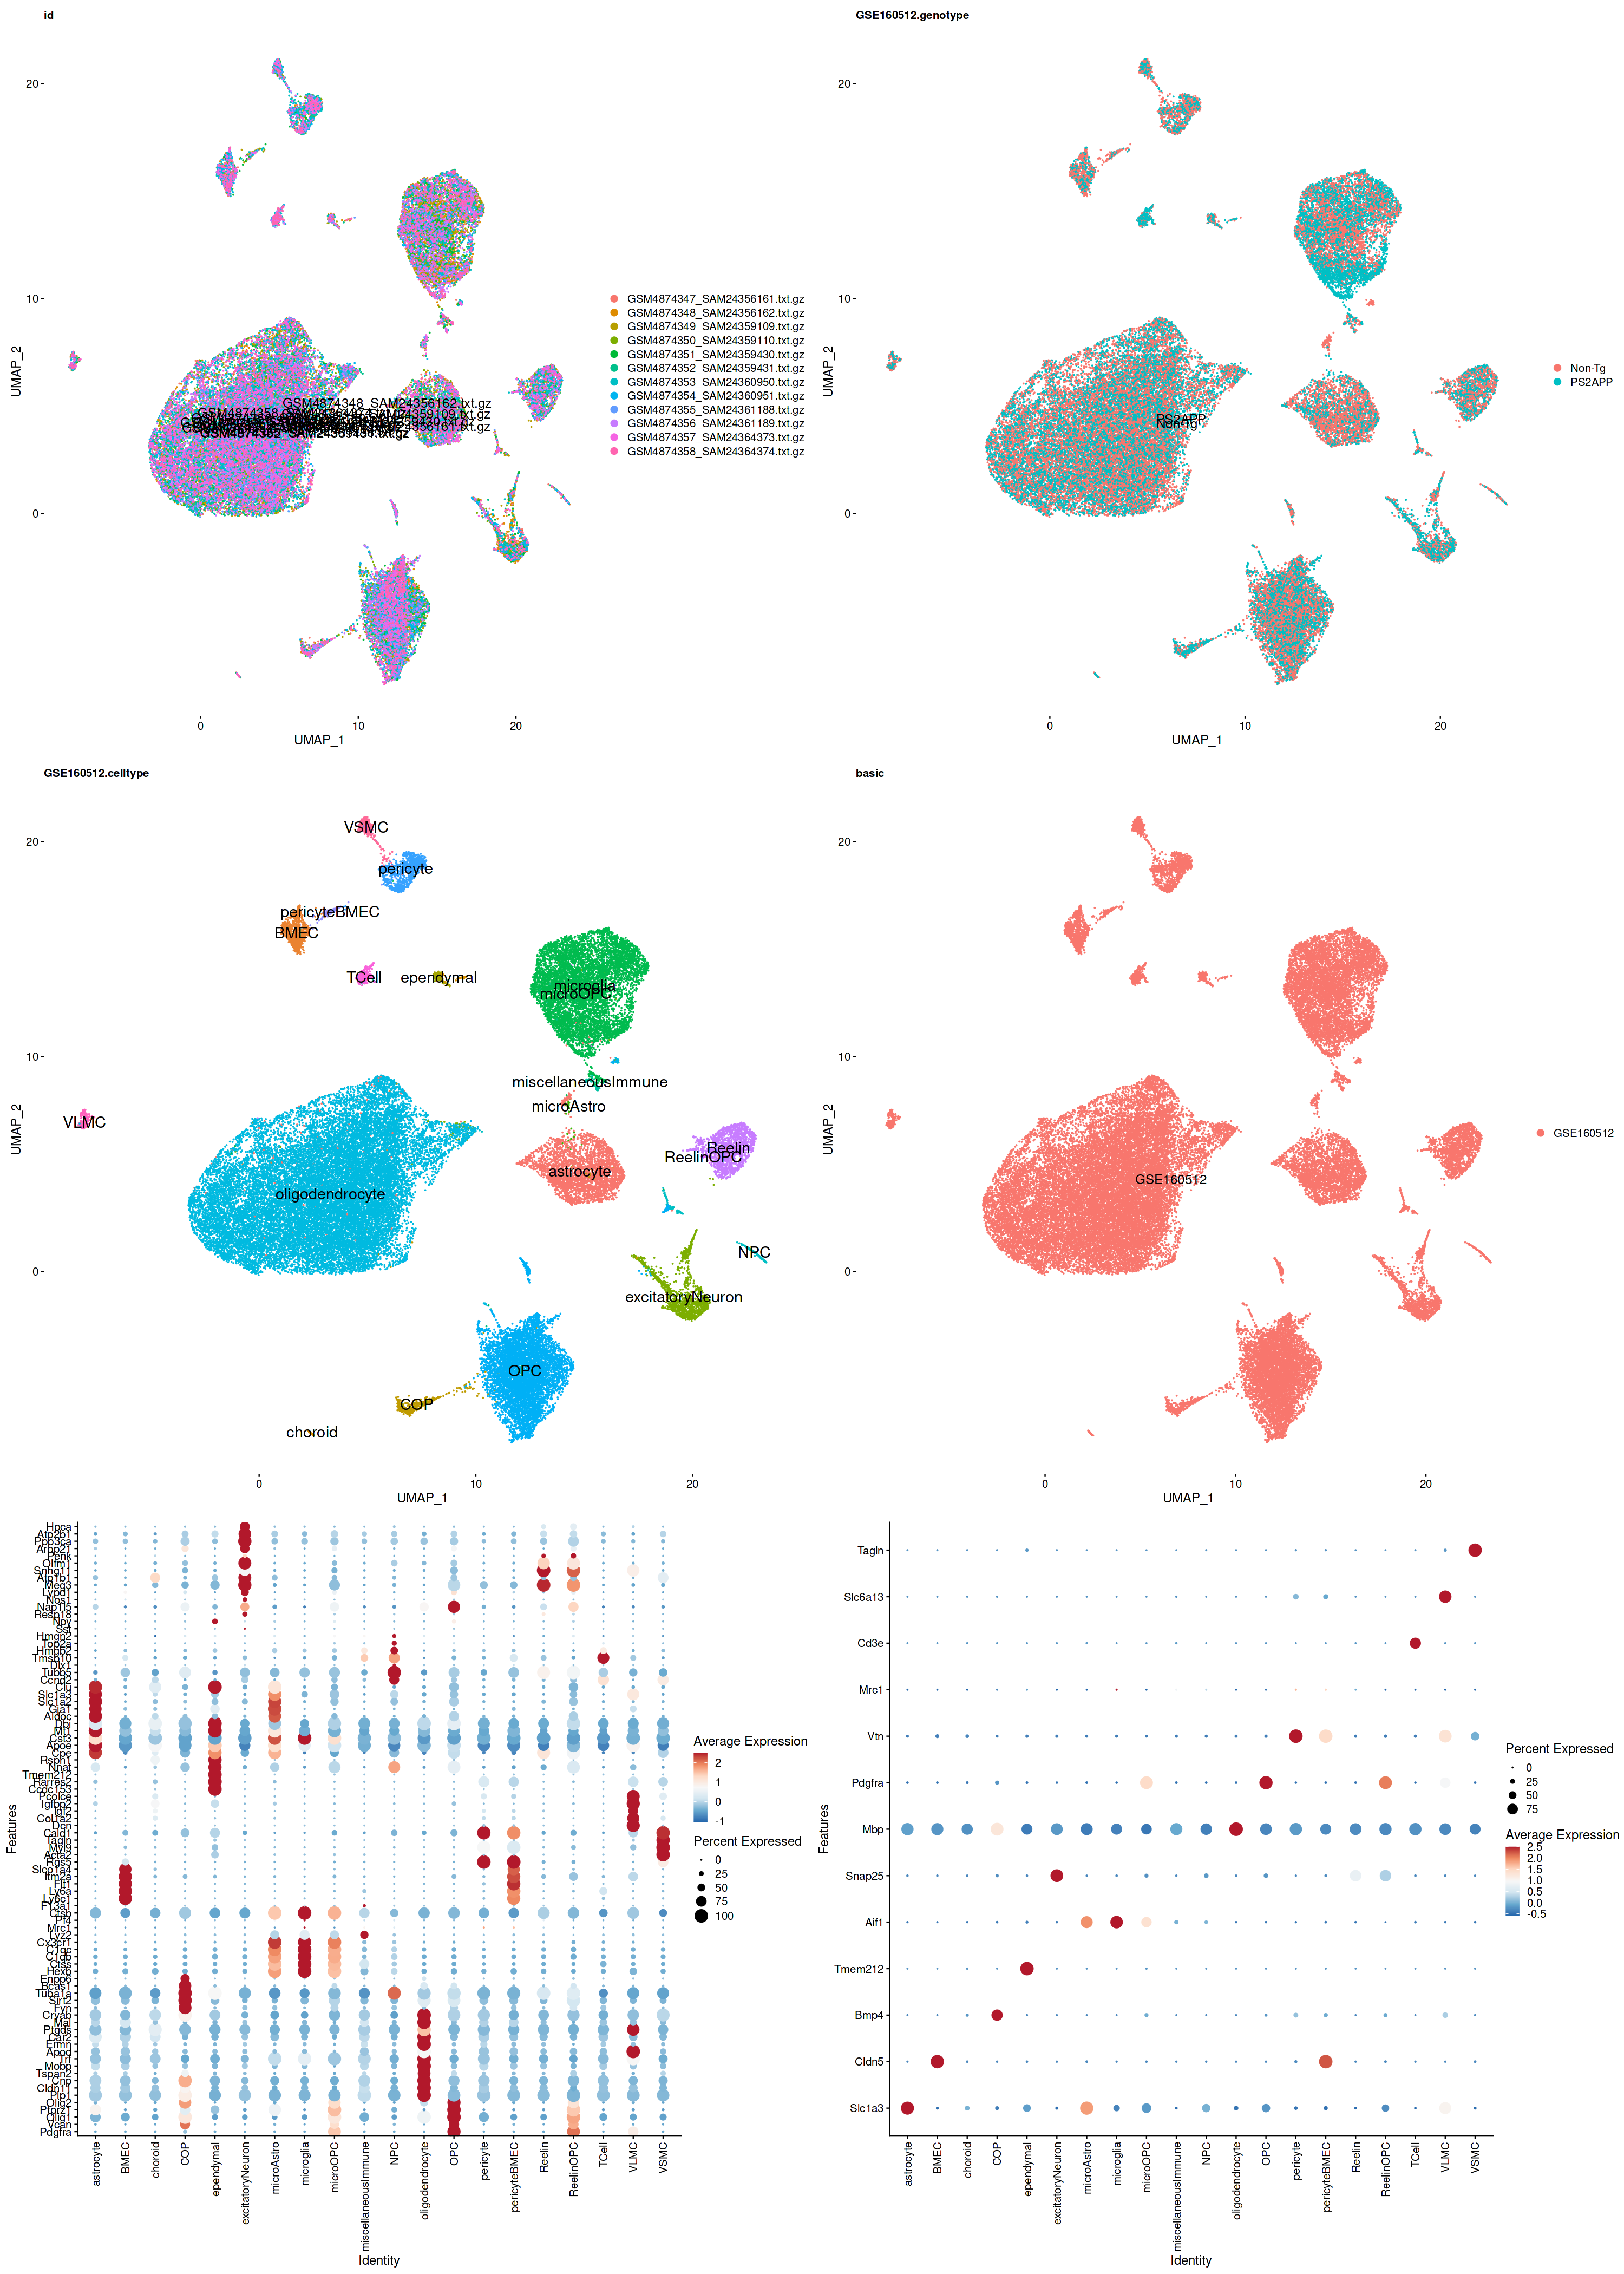

In [45]:
options(repr.plot.width = 25, repr.plot.height = 35)
p1 <- list()
p1[[1]] <- DimPlot(GSE160512.merge, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(GSE160512.merge, group.by = "GSE160512.genotype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(GSE160512.merge, group.by = "GSE160512.celltype", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(GSE160512.merge, group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[6]] <- DotPlot(GSE160512.merge, group.by = "GSE160512.celltype", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(GSE160512.merge, group.by = "GSE160512.celltype", features = c(c("Slc1a3",# astrocyte; 
                                                                                    "Cldn5", #(BMEC); 
                                                                                    "Bmp4", #(COP); 
                                                                                    "Tmem212", #ependymal cell; 
                                                                                    "Aif1", # microglia; 
                                                                                    "Snap25", #neuron; 
                                                                                    "Mbp", #oligodendrocyte; 
                                                                                    "Pdgfra", #OPC; 
                                                                                    "Vtn", #pericyte, 
                                                                                    "Mrc1", #perivascular macrophage (PVM); 
                                                                                    "Cd3e", #T cell; 
                                                                                    "Slc6a13", # (VLMC); 
                                                                                    "Tagln")  # (VSMC).
                                                                              ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], p1[[6]], p1[[7]], ncol=2) 

# "Ccnd2","Tubb5","Dlx1","Tmsb10","Tuba1a", #NSC
# "Hmgb2","Top2a","Hmgn2","Tubb5","H2afz", # NSC    

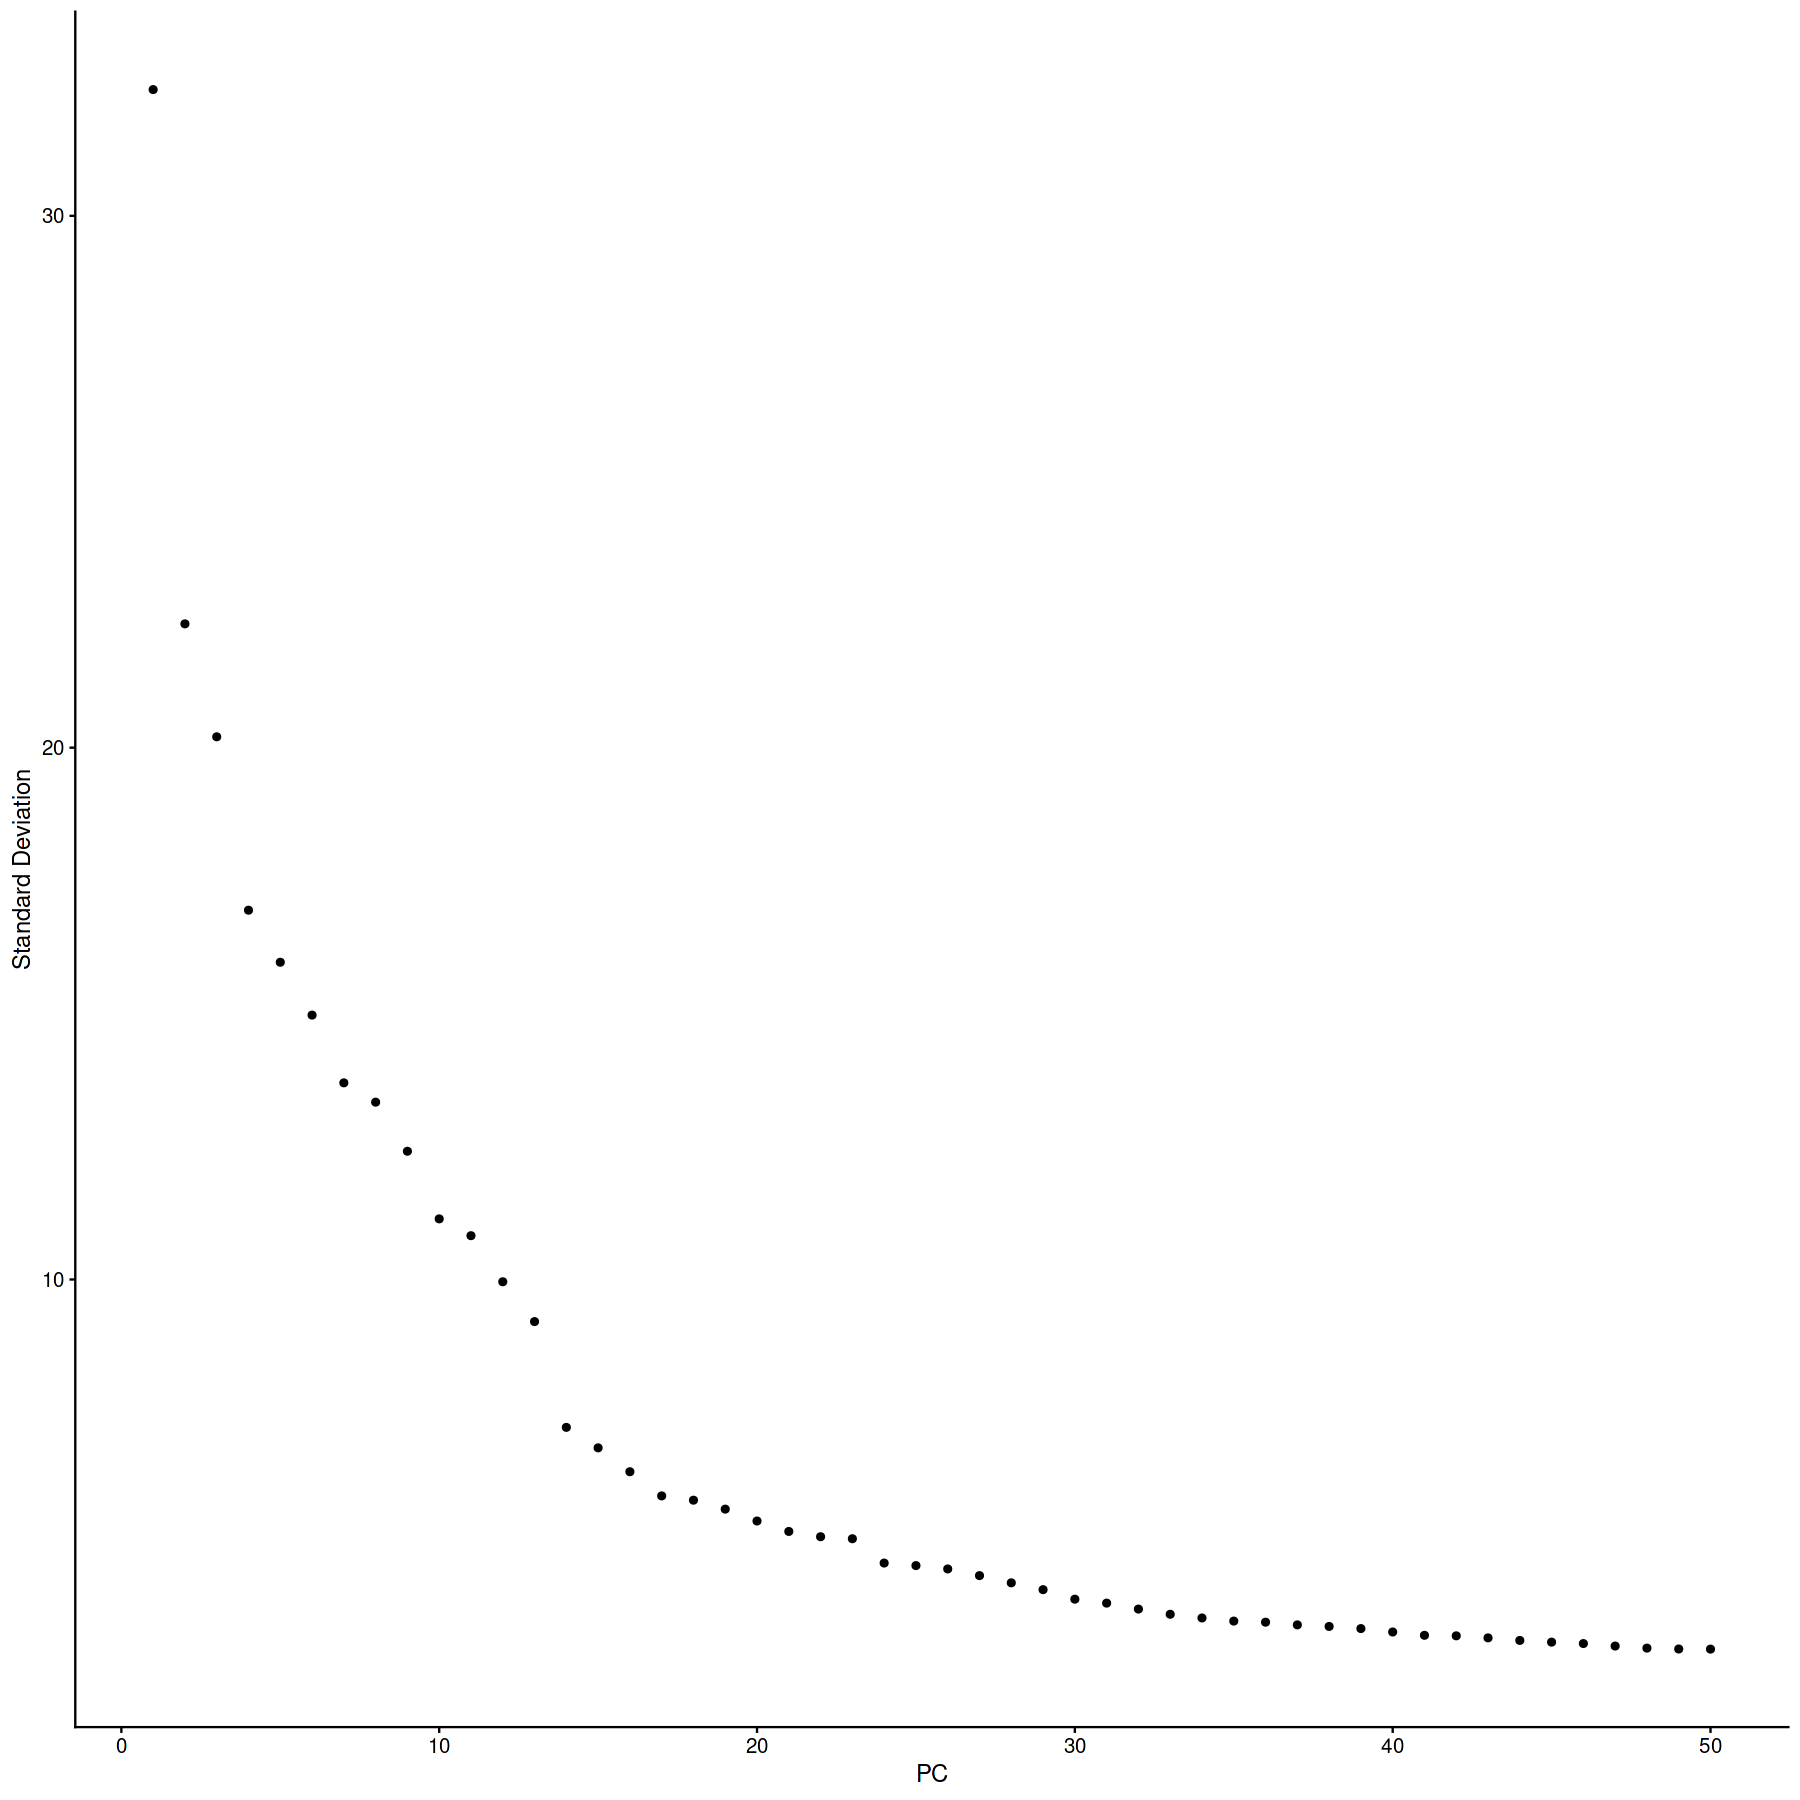

In [41]:
ElbowPlot(GSE160512.merge, 50)

In [94]:
kelly.colours[c(4,12,13)] <- 

[1] "plum4"        "deepskyblue4" "lightsalmon2"

In [7]:
GSE160512.merge.oligo <- GSE160512.merge[,grep("^OPC|^oligo|COP", GSE160512.merge$GSE160512.celltype)]


In [106]:
length(kelly.colours)

[1] 22

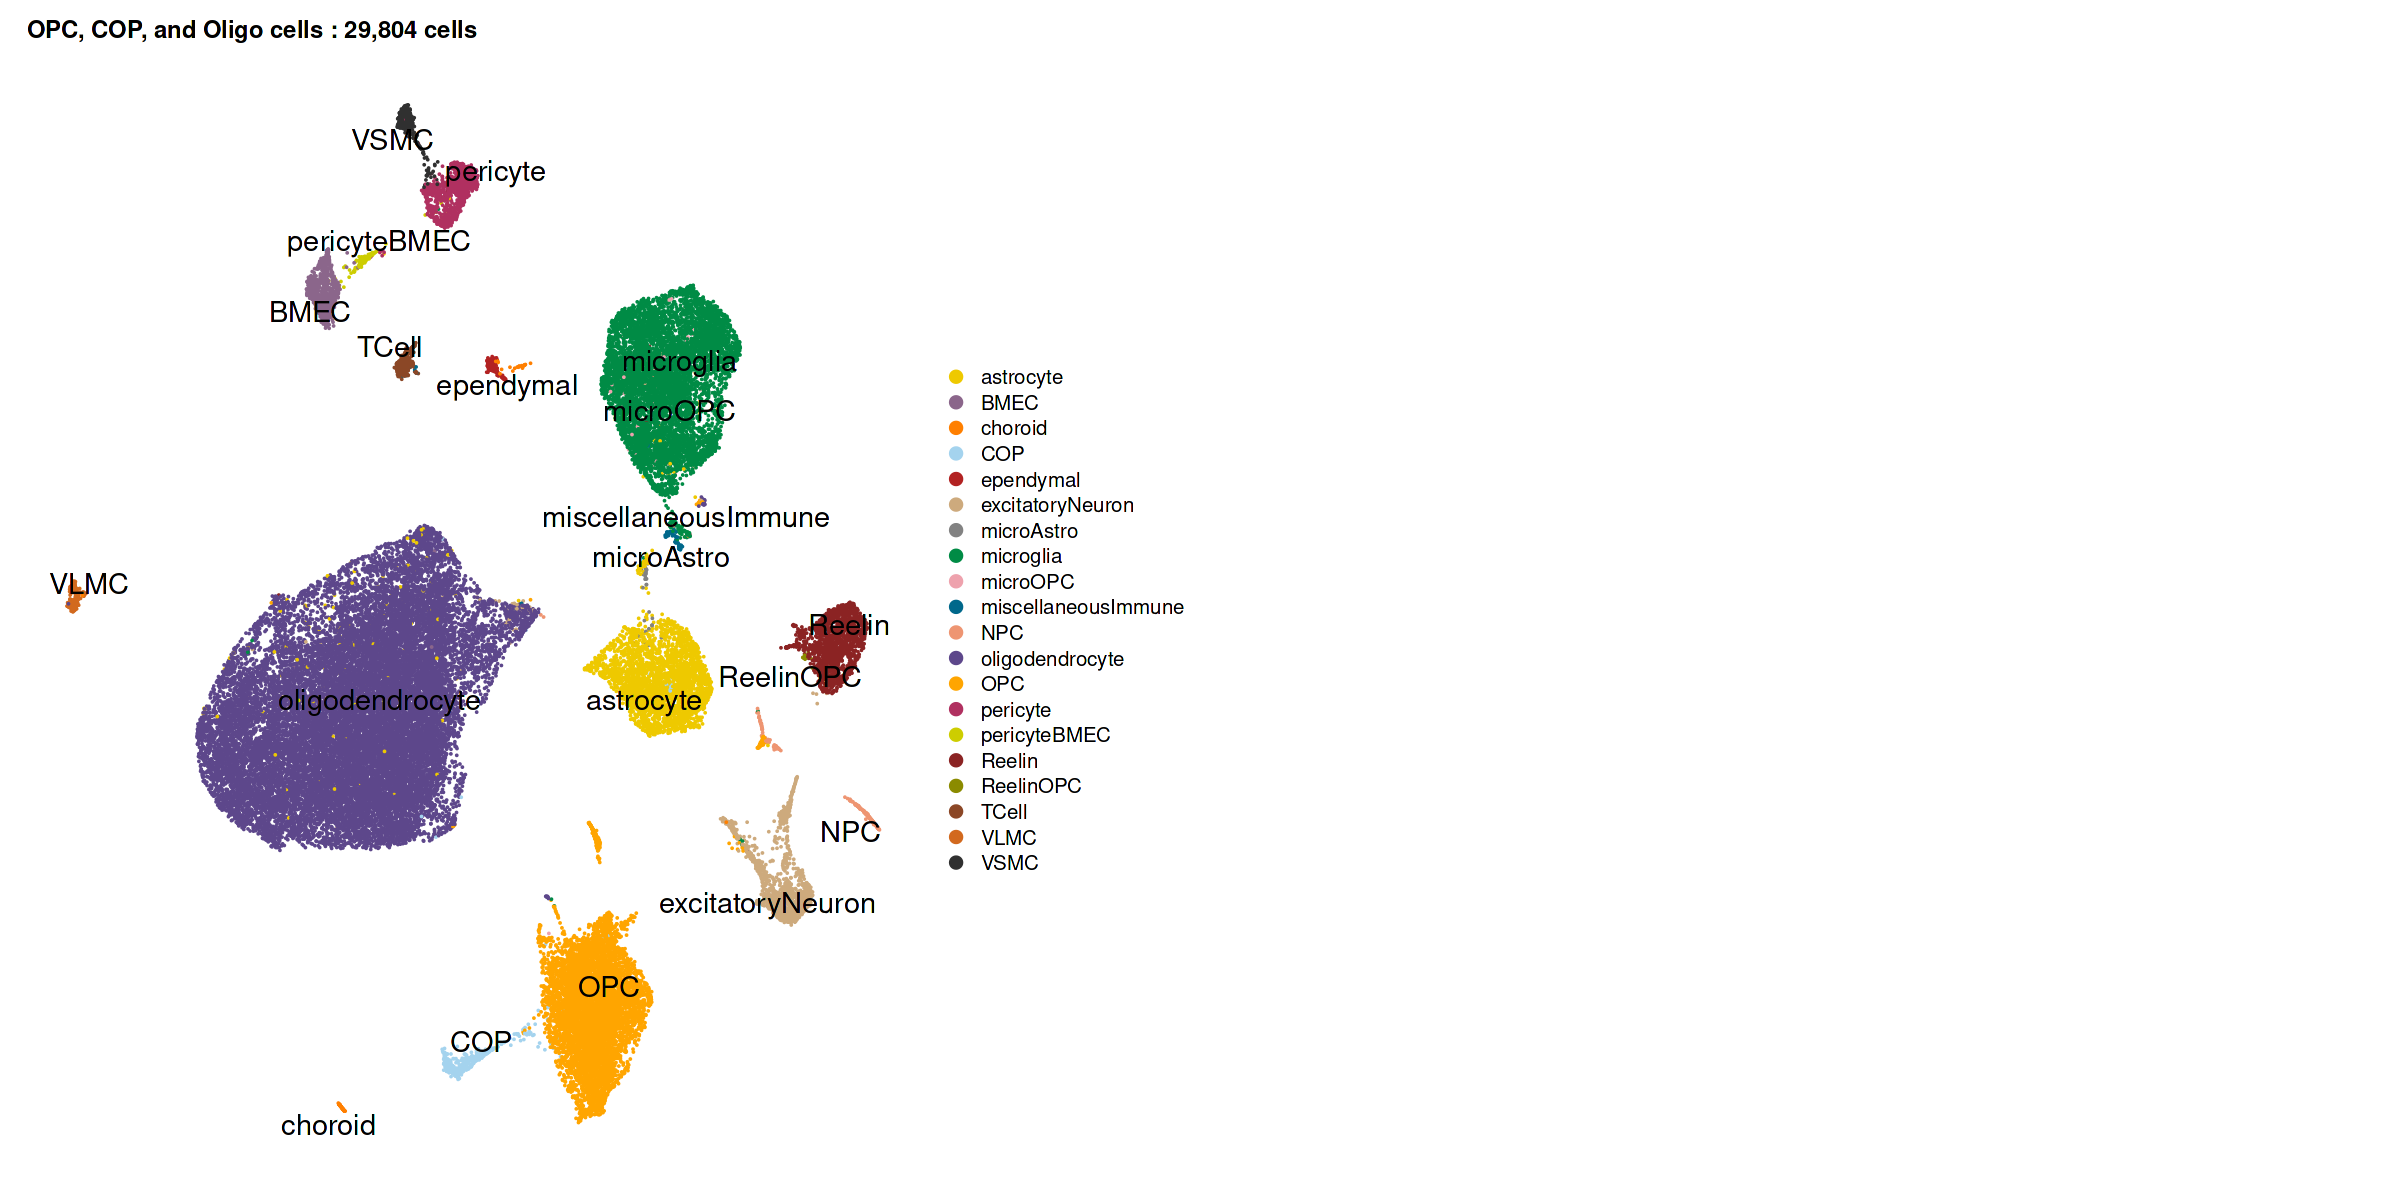

In [149]:
kelly.colours <- c("gray95", "gray13", "gold2", "plum4", "darkorange1", "lightskyblue2", "firebrick", "burlywood3", "gray51", "springgreen4", "lightpink2", "deepskyblue4", "lightsalmon2", "mediumpurple4", "orange", "maroon", "yellow3", "brown4", "yellow4", "sienna4", "chocolate", "gray19")

options(repr.plot.width = 20, repr.plot.height = 10)
p1 <- list()

p1[[1]] <-DimPlot(GSE160512.merge, 
        sizes.highlight=0.1,
        # cells.highlight = colnames(GSE160512.merge.oligo),
        # cols.highlight= brewer.pal(12,"Set3")[1:3],
        reduction = "umap", group.by = "GSE160512.celltype", label = T, repel = T, 
        label.size = 6, pt.size = 0.01, 
        cols = kelly.colours[3:22]) + 
  theme( axis.title = element_blank(), 
        plot.title = element_text(size = 14, face = "bold",hjust = 0), axis.line = element_blank(), 
        axis.text = element_blank(),  axis.ticks = element_blank()) + 
  ggtitle(paste0("OPC, COP, and Oligo cells : ",comma(length(colnames(GSE160512.merge.oligo)),format="d")," cells"))


 
plot_grid(p1[[1]], ncol=2) 



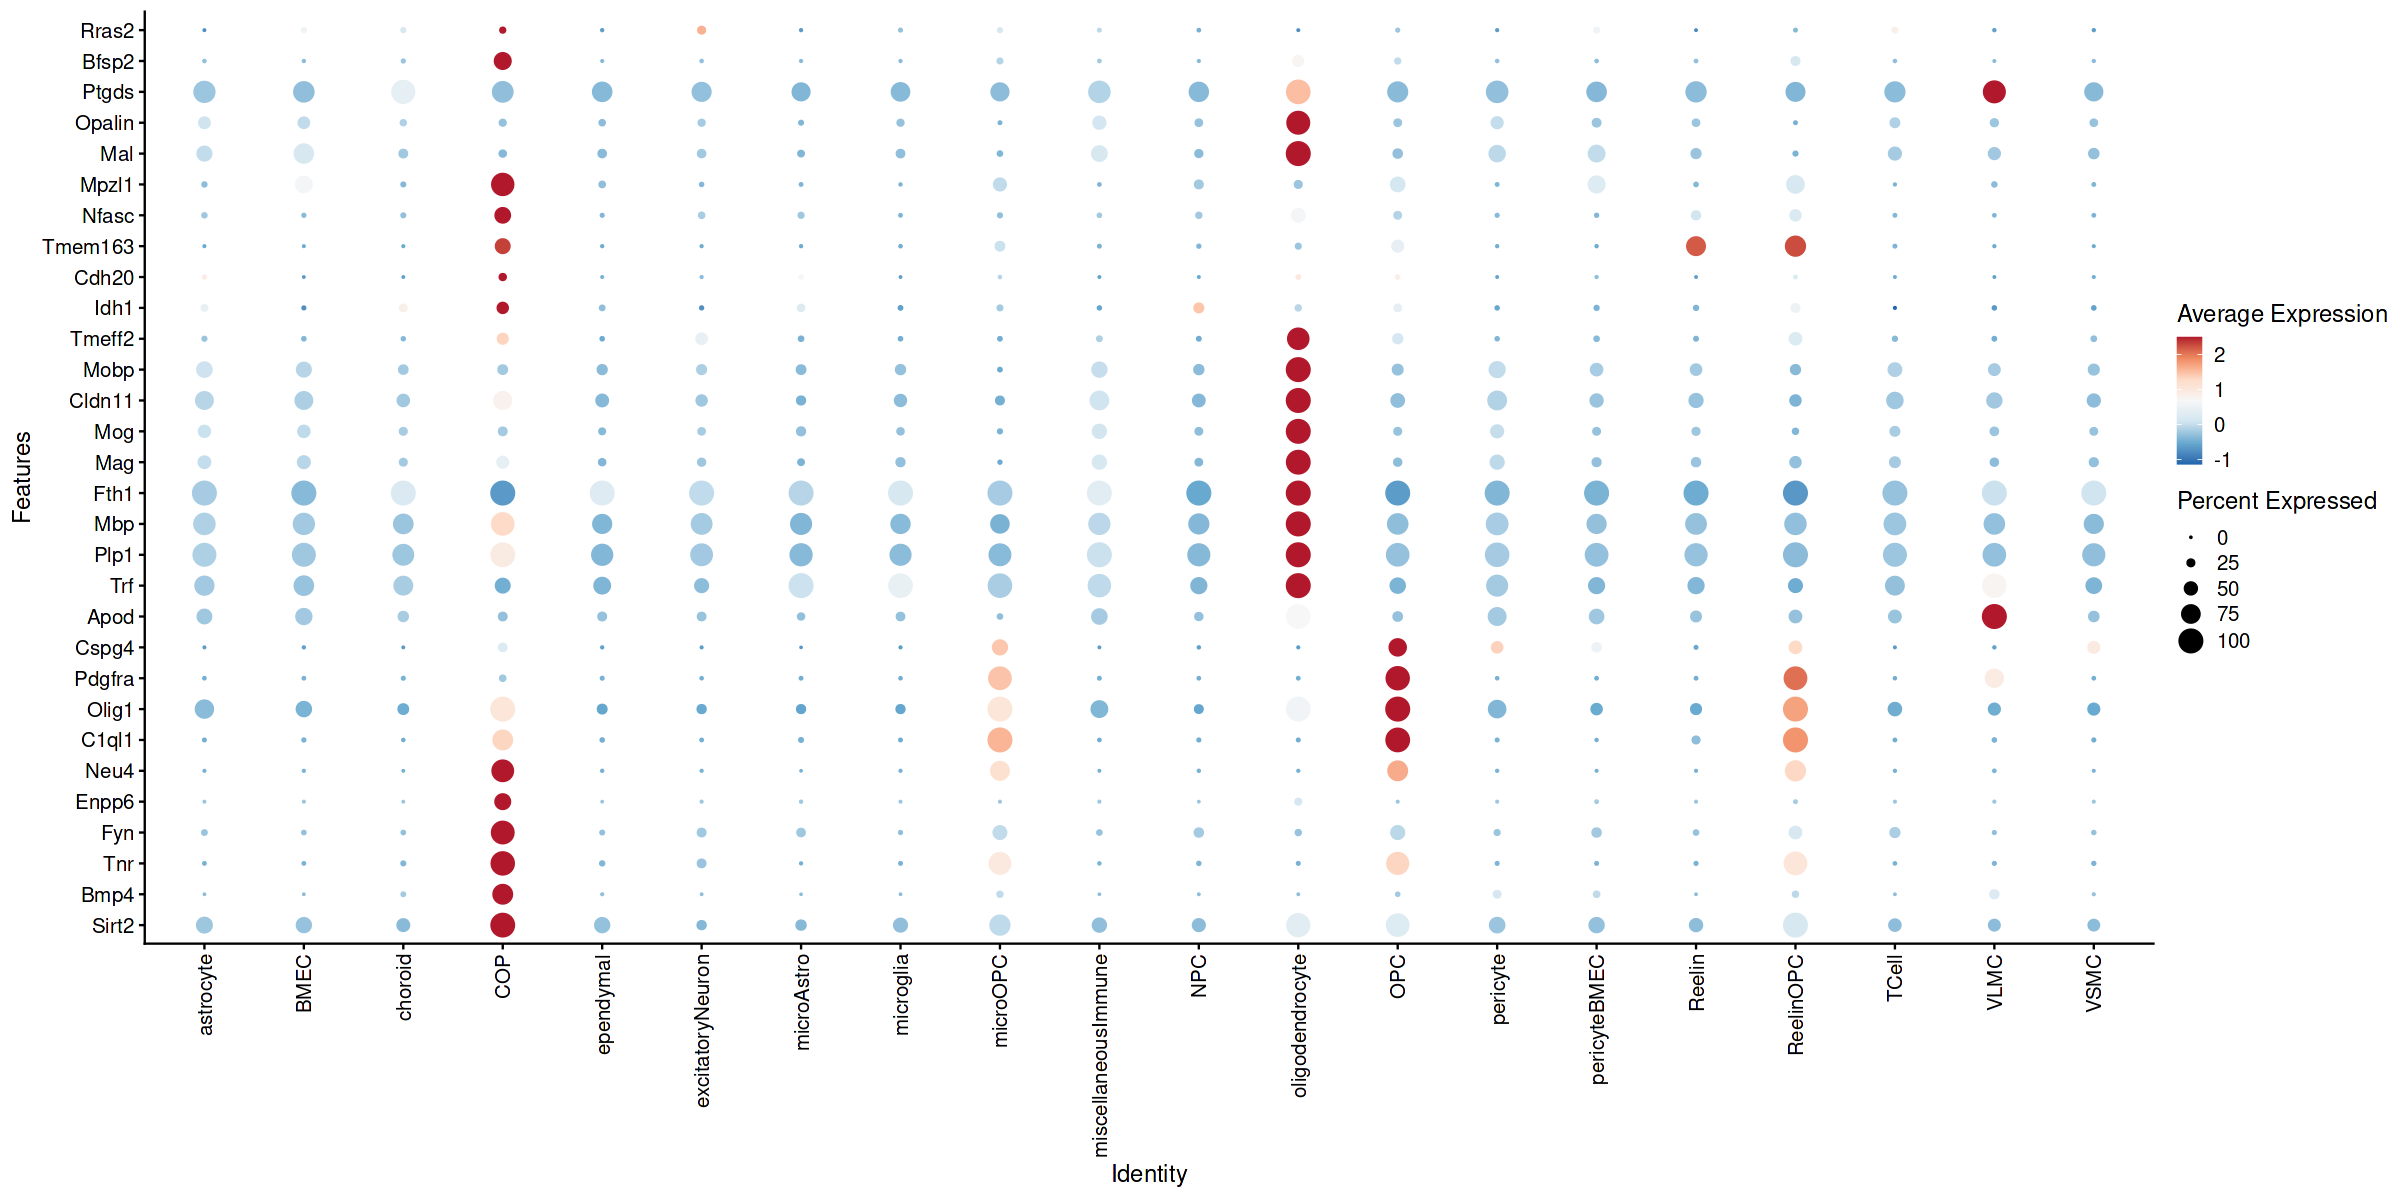

In [65]:
DotPlot(GSE160512.merge, group.by = "GSE160512.celltype", features = unique(c(oligo.mark,"Rras2")), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:

GSE160512.merge.oligo <- GSE160512.merge[,grep("^OPC|^oligo|COP", GSE160512.merge$GSE160512.celltype)]


In [152]:

require("scProportionTest")
prop_test <- sc_utils(GSE160512.merge.oligo)

prop_test.1 <- permutation_test(
  prop_test, cluster_identity = "GSE160512.celltype",
  sample_1 = "Non-Tg", sample_2 = "PS2APP",
  sample_identity = "GSE160512.genotype"
)

p1[[2]] <- permutation_plot(prop_test.1,FDR_threshold = 0.01, log2FD_threshold = log2(1.2))+
  theme(legend.position = 'bottom', 
        legend.title = element_text(size = 12, hjust = 0),
        legend.text = element_text(size = 10),
        axis.title = element_text(size = 12, face = "bold"),
        axis.text = element_text(size = 10))+
  ggtitle("PS2APP vs Non-Tg") +
  theme(plot.title = element_text(size = 14, face = "bold",hjust = 0))

options(repr.plot.width=15, repr.plot.height=10)

library(dittoSeq)
pt <- prop.table(table(GSE160512.merge.oligo$GSE160512.celltype, GSE160512.merge.oligo$GSE160512.genotype), margin = 2)
pt <- as.data.frame(pt)
pt$Var1 <- as.character(pt$Var1)

# selLabel<-intersect(prop_test@results$permutation$clusters[prop_test@results$permutation$FDR<0.01],
#                     prop_test@results$permutation$clusters[abs(prop_test@results$permutation$obs_log2FD)>0.53])
# library(ggrepel)
# prop.table(table(Idents(combined), combined$id_new), margin = 2)

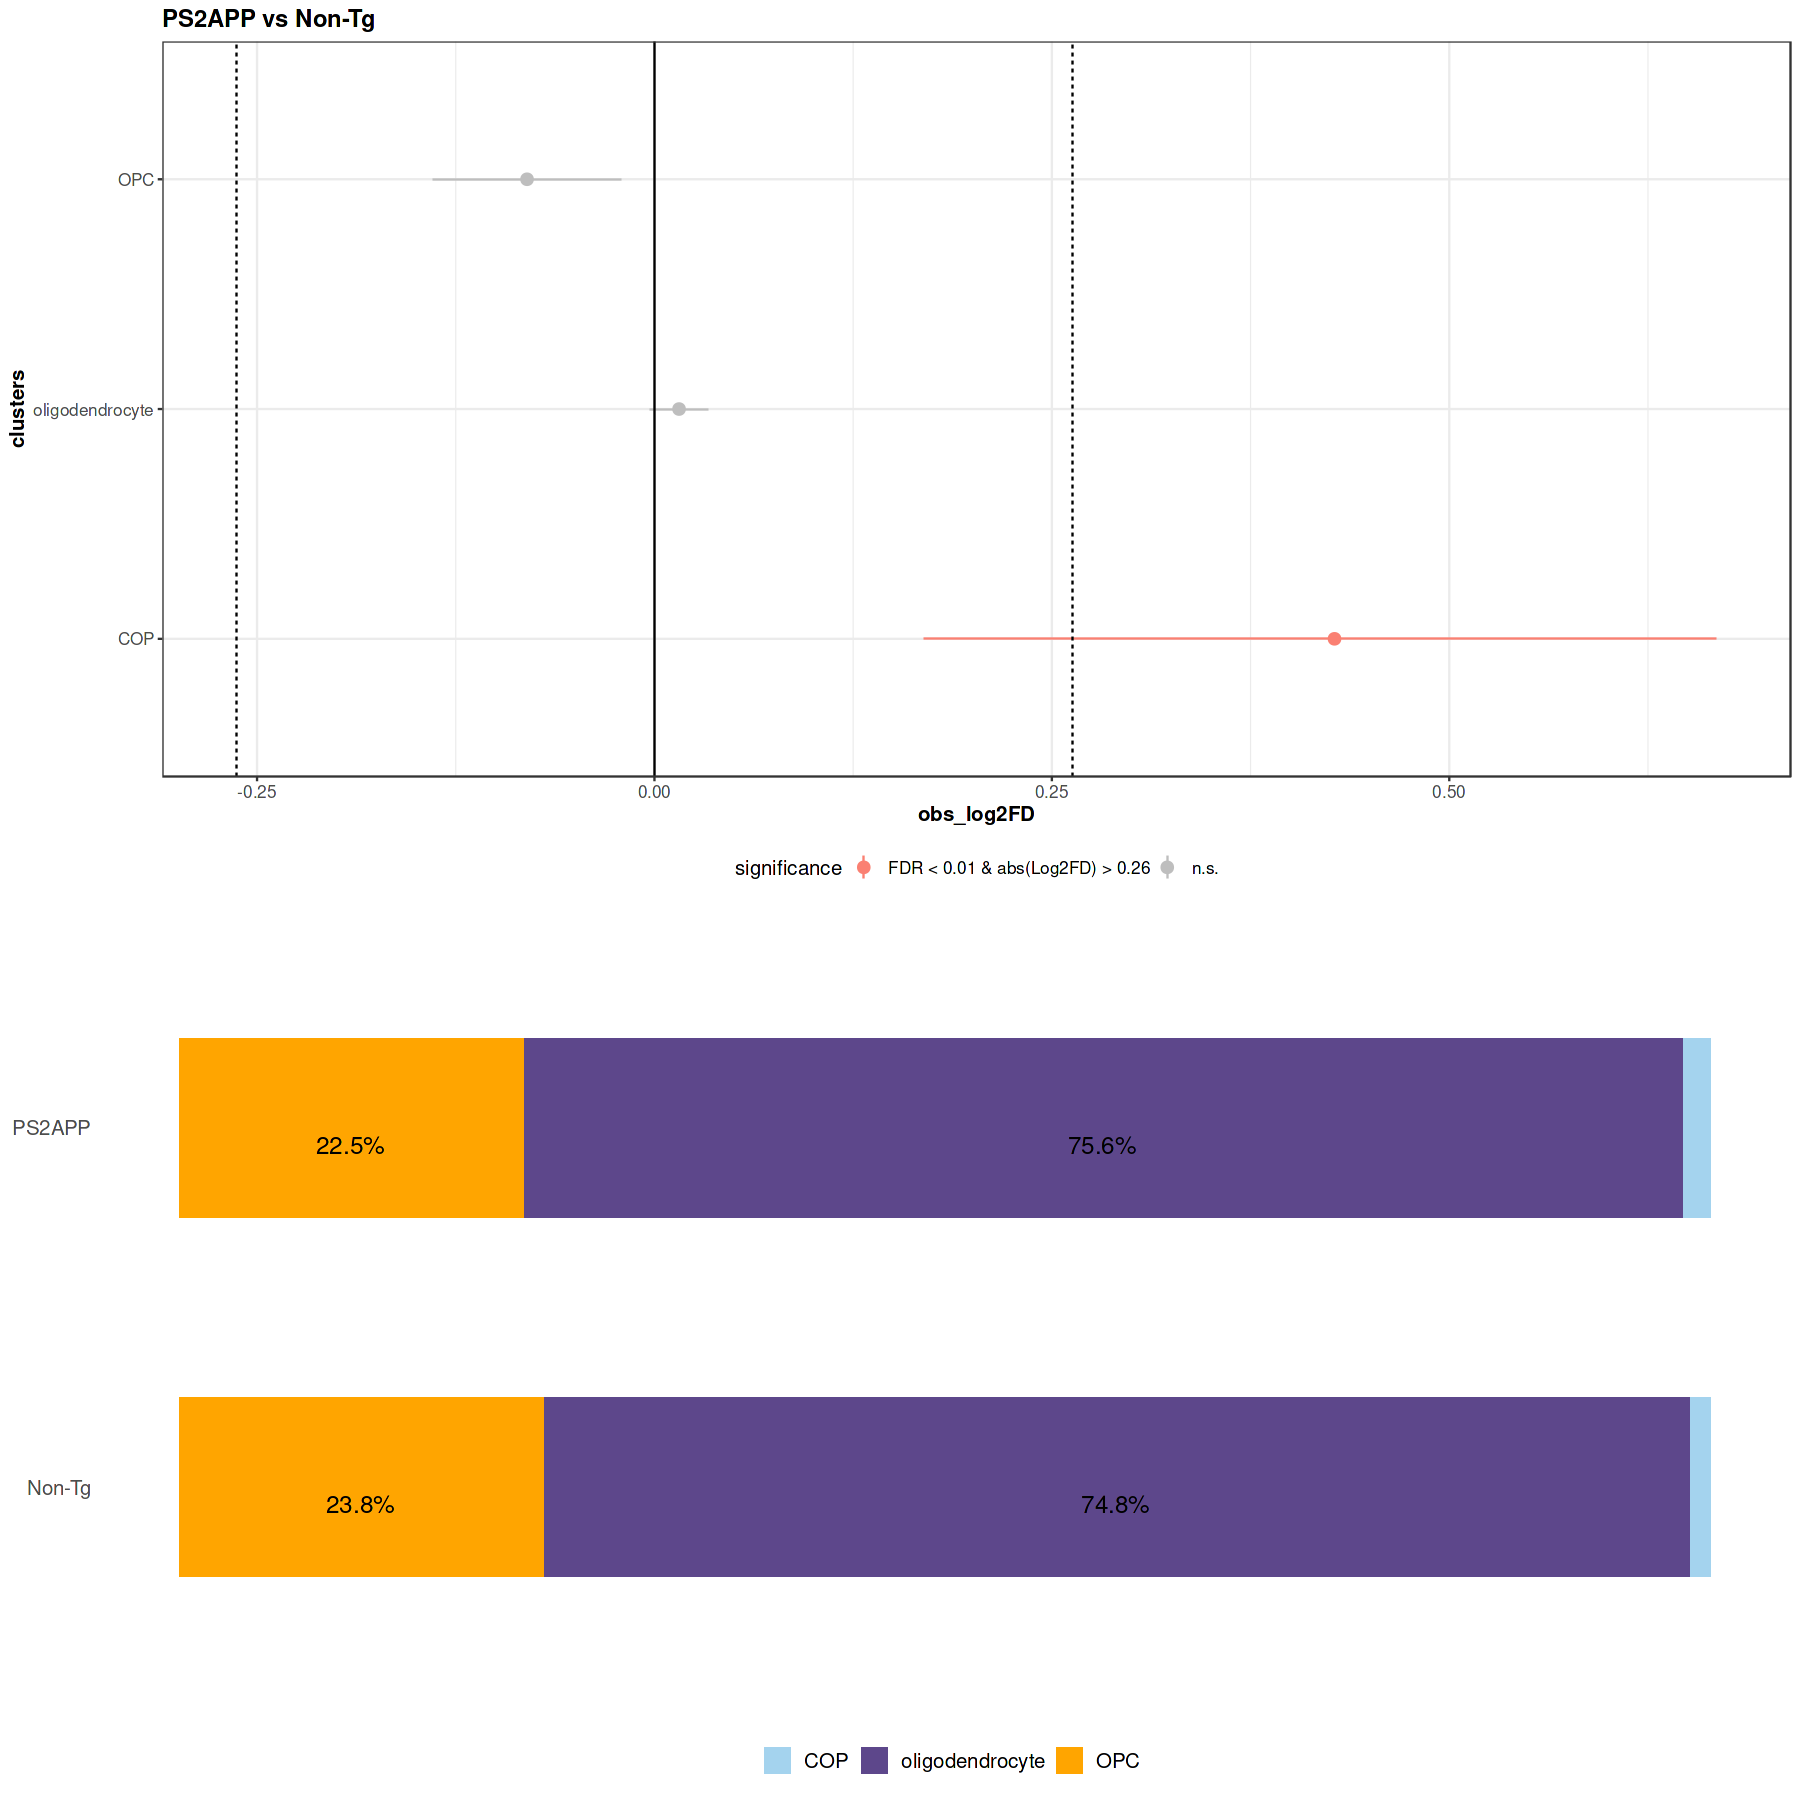

In [153]:

p1[[3]] <- ggplot(pt, aes(x = Var2, y = Freq, fill = reorder(Var1,1:dim(pt)[1]), label = ifelse(Freq>0.025,scales::percent(Freq, accuracy=.1),""))) +
  theme_bw(base_size = 15) +
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
  geom_col(position = "fill", width = 0.5) +
  geom_text_repel(position = position_fill(vjust = 0.5), 
            vjust=0.2,
            hjust=-0.1,
            size = 5,
            max.overlaps = 10,
            box.padding = unit(0.5, "lines"),
            direction = "y") + 
  theme(axis.title = element_blank(), axis.line = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(),
        plot.title = element_text(size = 14, face = "bold",hjust = 0)) +
  scale_fill_manual(values = kelly.colours[3:22][c(4,12,13)]) +
  theme(legend.position = 'bottom')+
  theme(legend.title = element_blank())+  coord_flip()

options(repr.plot.width=15, repr.plot.height=15)

plot_grid(p1[[2]], p1[[3]], ncol=1)

In [154]:

ggsave("/home/choelab/working/OL_sorted/results/GSE160512/fig1-1.pdf", device = "pdf", plot = p1[[1]], width = 10, height = 10, units = "in", dpi = 500)
ggsave("/home/choelab/working/OL_sorted/results/GSE160512/fig1-2.pdf", device = "pdf", plot = p1[[2]], width = 10, height = 10, units = "in", dpi = 500)
ggsave("/home/choelab/working/OL_sorted/results/GSE160512/fig1-3.pdf", device = "pdf", plot = p1[[3]], width = 10, height = 10, units = "in", dpi = 500)


In [119]:
ggsave("/home/choelab/working/OL_sorted/results/GSE160512/fig1-1.png", device = "png", plot = p1[[1]], width = 10, height = 10, units = "in", dpi = 500)
ggsave("/home/choelab/working/OL_sorted/results/GSE160512/fig1-2.png", device = "png", plot = p1[[2]], width = 10, height = 10, units = "in", dpi = 500)
ggsave("/home/choelab/working/OL_sorted/results/GSE160512/fig1-3.png", device = "png", plot = p1[[3]], width = 10, height = 10, units = "in", dpi = 500)


In [ ]:
options(repr.plot.width=9, repr.plot.height=5)
DotPlot(GSE160512.merge.oligo[,GSE160512.merge.oligo$GSE160512.celltype == "oligodendrocyte"], group.by = "GSE160512.genotype", features = c("Bmp4","Enpp6","Sirt2", "Gpr17","App"),  assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

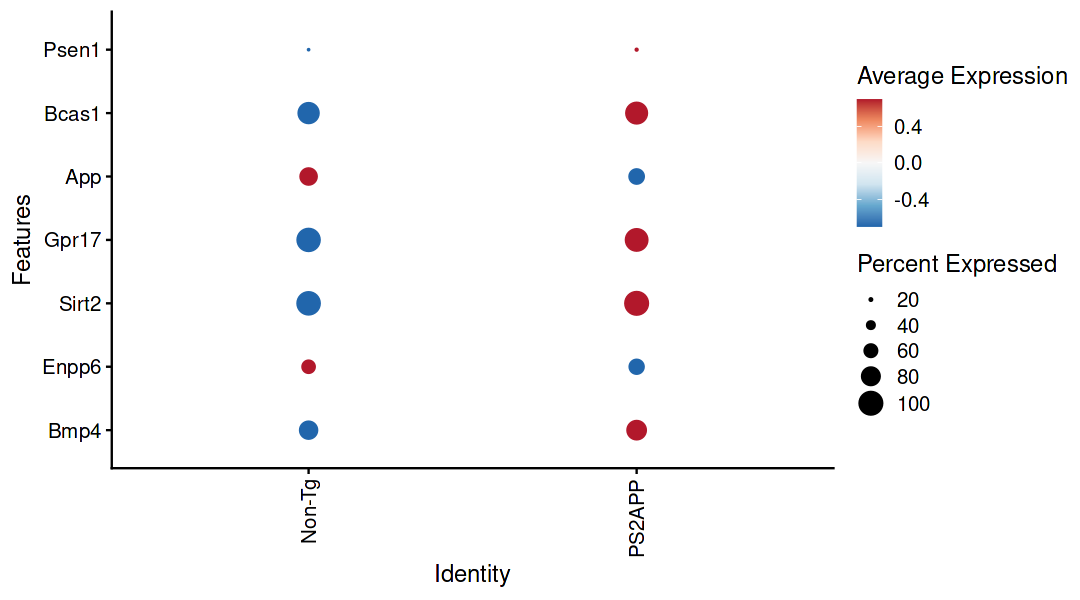

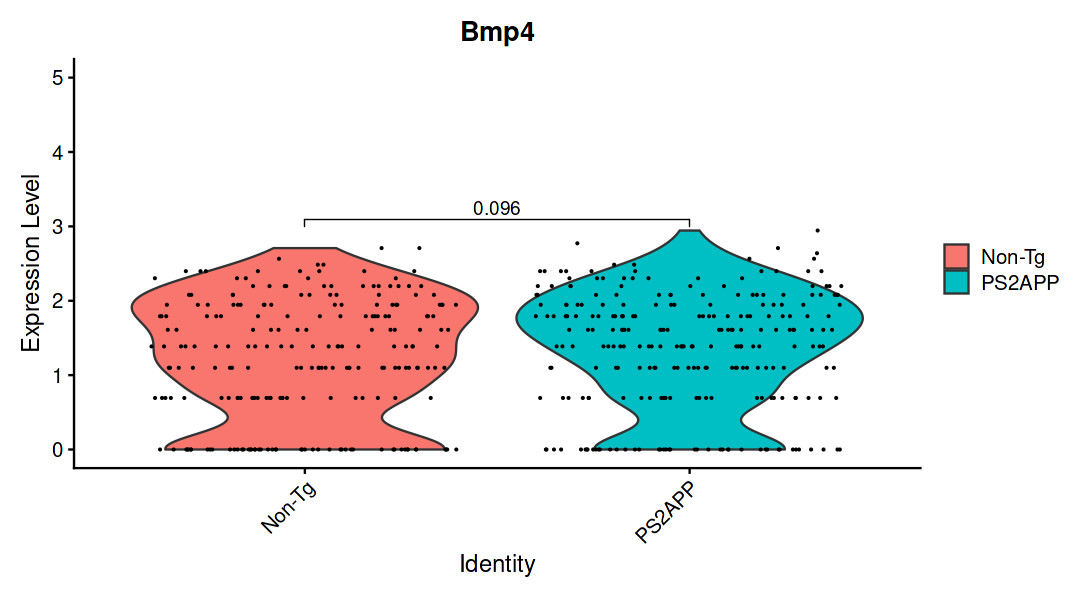

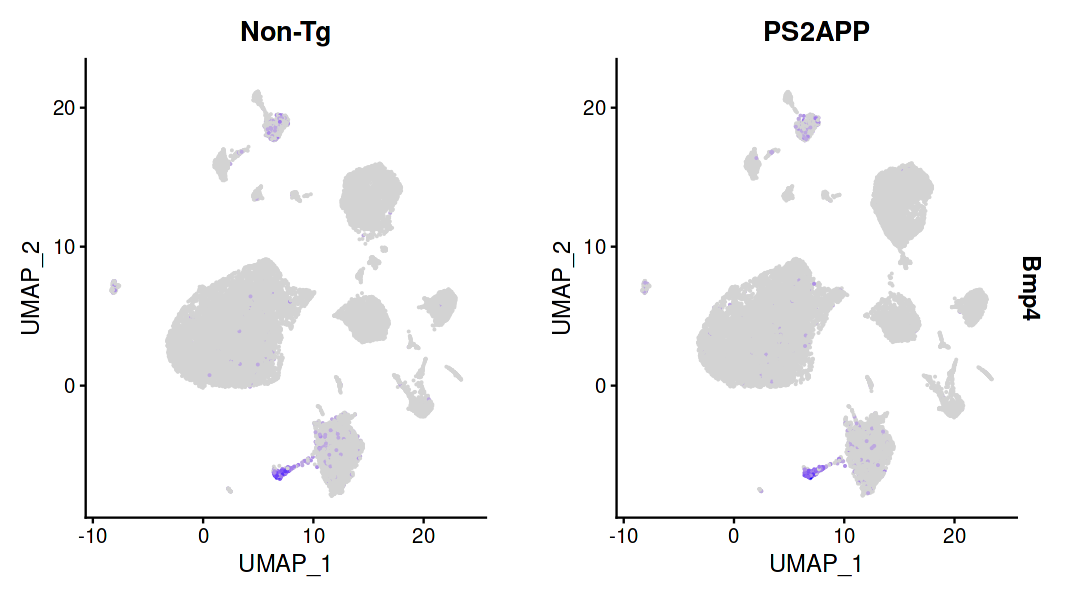

In [121]:
# options(repr.plot.width=16, repr.plot.height=8)
# DotPlot(GSE160512.merge, group.by = "GSE160512.celltype", features = c("Bmp4"), split.by="GSE160512.genotype", assay="SCT" , cols ="RdBu") + coord_flip() + 
#            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
COP <- GSE160512.merge[,GSE160512.merge$GSE160512.celltype == "COP"]
OPC <- GSE160512.merge[,GSE160512.merge$GSE160512.celltype == "OPC"]

options(repr.plot.width=9, repr.plot.height=5)
DotPlot(COP, group.by = "GSE160512.genotype", features = c("Bmp4","Enpp6","Sirt2", "Gpr17","App","Bcas1","Psen1"),  assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

   VlnPlot(COP, features = c("Bmp4"),pt.size = 0.1, assay="SCT" , group.by = "GSE160512.genotype",
            y.max = 5 # add the y-axis maximum value - otherwise p-value hidden
    ) + stat_compare_means(comparisons = list(c("Non-Tg", "PS2APP")))
FeaturePlot(GSE160512.merge, features = c("Bmp4"), split.by = "GSE160512.genotype")


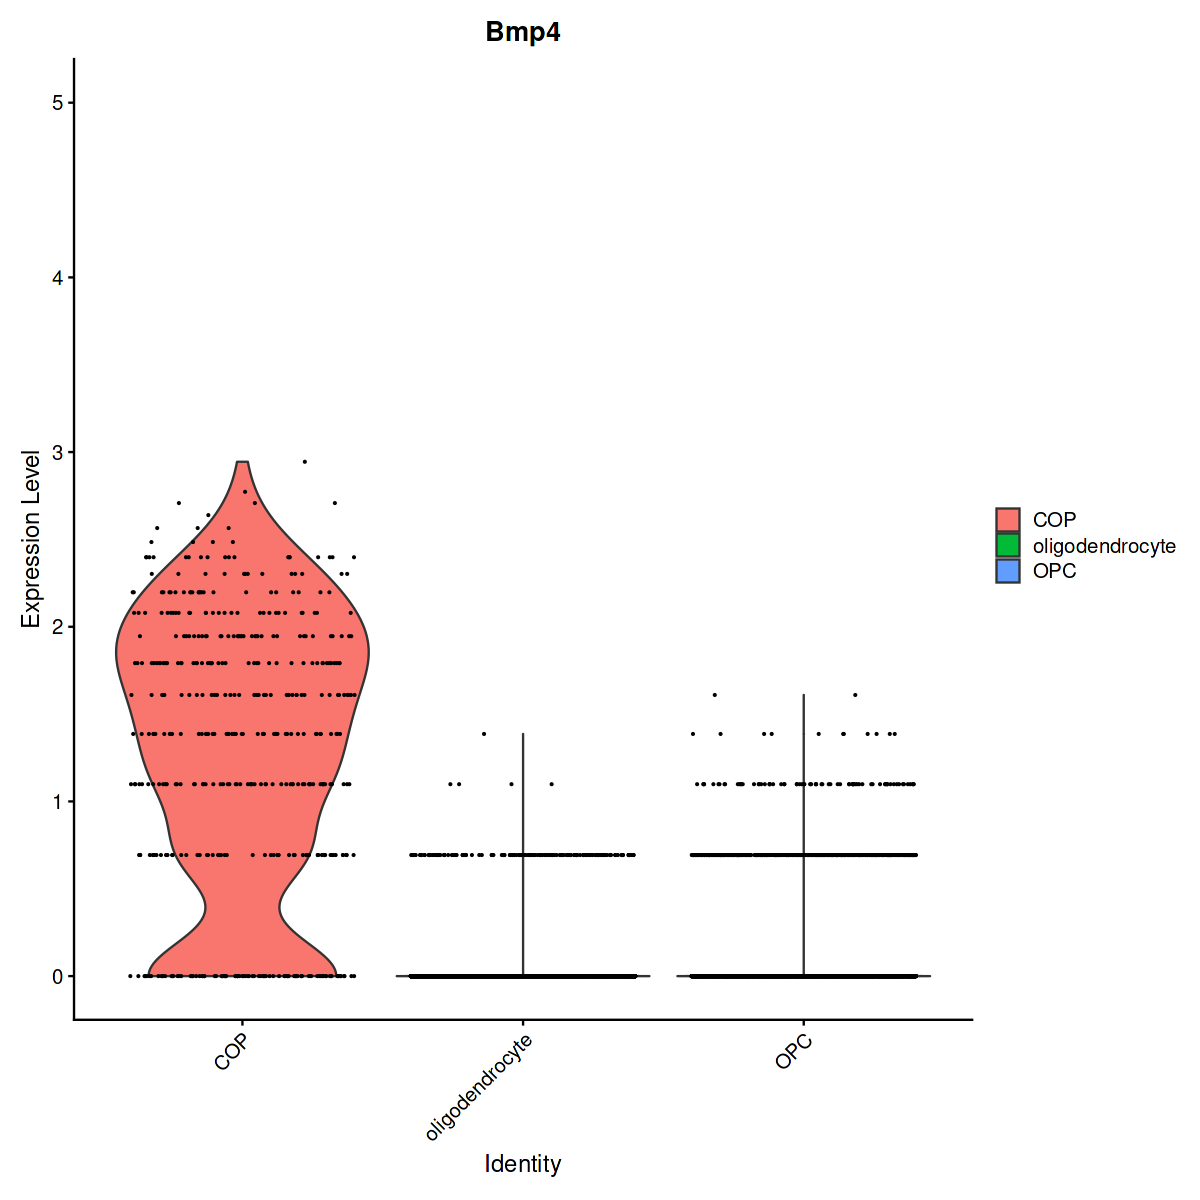

In [159]:
   VlnPlot(GSE160512.merge[,grep("oligo|^OPC|COP",GSE160512.merge$GSE160512.celltype)], features = c("Bmp4"),pt.size = 0.1, assay="SCT" , group.by = "GSE160512.celltype",
            y.max = 5 # add the y-axis maximum value - otherwise p-value hidden
    )

In [146]:

Idents(GSE160512.merge.oligo) <- "GSE160512.celltype"
COP.OPC.marker <- FindMarkers(GSE160512.merge.oligo, assay = "SCT", ident.1 = "COP", ident.2="OPC", min.pct = 0.001, logfc.threshold = 0.001)

In [147]:

selgene <- c(rownames(arrange(COP.OPC.marker, desc(avg_log2FC)))[1:6], rownames(arrange(COP.OPC.marker, avg_log2FC))[1:6])

In [134]:
selgene

[1] "Fyn"           "Bmp4"          "Gp1bb"         "Enpp6"        
 [5] "9530059O14Rik" "Slc44a1"       "Bcas1"         "Mycl"         
 [9] "Septin5"       "Mpzl1"         "Cspg5"         "Pdgfra"       
[13] "Ccnd1"         "Kcnip3"        "Cdo1"          "Ptn"          
[17] "Rlbp1"         "Ednrb"         "Olfm2"         "Ptprz1"

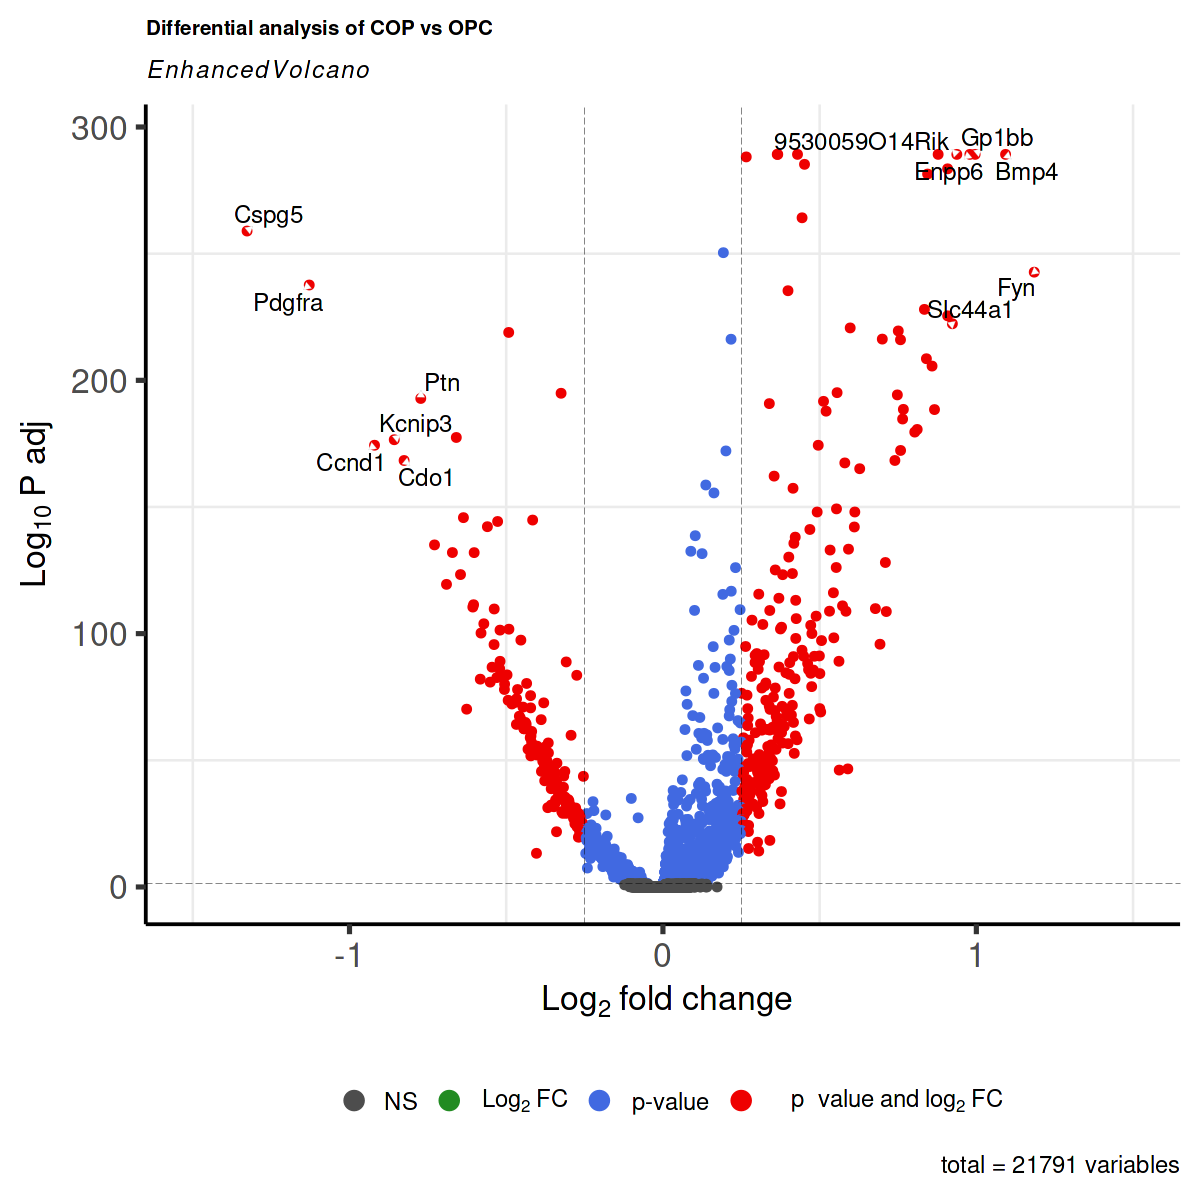

In [155]:

#   keyvals.shape <- ifelse(drv1_$gene %in% top_up1, 24, ifelse(drv1_$gene %in% top_dn1, 25, 20))
#   names(keyvals.shape) <- ifelse(drv1_$gene %in% top_up1, "Up", ifelse(drv1_$gene %in% top_dn1, "Down", "ns"))
#   keyvals.colour <- ifelse((drv1_$avg_log2FC < -fc) & (drv1_$p_val_adj < p.adj), 'royalblue', ifelse((drv1_$avg_log2FC > fc) & (drv1_$p_val_adj < p.adj), 'red', 'lightgrey'))
#   keyvals.colour[drv1_$gene %in% before.gene] <- 'forestgreen'        
#   keyvals.colour[is.na(keyvals.colour)] <- 'lightgrey'
#   names(keyvals.colour)[keyvals.colour == 'lightgrey'] <- 'ns'
#   names(keyvals.colour)[keyvals.colour == 'forestgreen'] <- 'Both'
#   names(keyvals.colour)[keyvals.colour == 'red'] <- 'Up genes'
#   names(keyvals.colour)[keyvals.colour == 'royalblue'] <- 'Down genes'
    
library(EnhancedVolcano)
options(repr.plot.width=10, repr.plot.height=10)

p1[[4]] <- EnhancedVolcano(COP.OPC.marker,
                        lab = rownames(COP.OPC.marker),
                        x = 'avg_log2FC',
                        y = 'p_val_adj',
                        xlim = c(-1.5, 1.5),
                        # ylim = c(-1, 10),
                        title =  paste0("Differential analysis of COP vs OPC " ),
                        # subtitle = class[1],
                        xlab = bquote(~Log[2]~ 'fold change'),
                        ylab = bquote(~-Log[10]~ 'P adj'),
                        # xlim = c(-xlims[1],xlims[1]),
                        pCutoff = 0.05,
                        FCcutoff = 0.25,
                        pointSize = 2,
                        selectLab = selgene,
                        # shapeCustom = keyvals.shape,
                        # colCustom = keyvals.colour,
                        # col=c("grey30", "forestgreen", "royalblue", "red2"),
                        #                colCustom = keyvals,
                        colAlpha = 1,
                        # legendPosition = 'none',
                        drawConnectors = TRUE,
                        widthConnectors = 0.05,
                        colConnectors = 'grey',
                        labSize = 5,
                        # labCol = "black",
                        axisLabSize = 20,
                        titleLabSize = 12,
                        # subtitleLabSize = 10,
                        legendPosition = 'bottom',
                        # caption = paste0("up = ", length(top_up1) , "\n down = ", length(top_dn1), "\n common = ", length(before.gene)),
                        # captionLabSize = 10,
                        cutoffLineWidth = 0.1,
                        gridlines.major = F,
                        gridlines.minor = T,
                        maxoverlapsConnectors =10)
    
p1[[4]]

In [156]:

ggsave("/home/choelab/working/OL_sorted/results/GSE160512/fig1-4.pdf", device = "pdf", plot = p1[[4]], width = 10, height = 10, units = "in", dpi = 500)
ggsave("/home/choelab/working/OL_sorted/results/GSE160512/fig1-4.png", device = "png", plot = p1[[4]], width = 10, height = 10, units = "in", dpi = 500)


In [ ]:
OLs.merge1.id <- readRDS("/home/choelab/working/OL_sorted/results/OLs.merge1.id.rds")
OLs.merge1.id.oligo <- readRDS("/home/choelab/working/OL_sorted/results/OLs.merge1.id.oligo.rds")

In [ ]:
options(repr.plot.width = 25, repr.plot.height = 35)
p1 <- list()
p1[[1]] <- DimPlot(OLs.merge1.id, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.merge1.id, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.merge1.id, group.by = "SCT_snn_res.0.2", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.merge1.id, group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[6]] <- DotPlot(OLs.merge1.id, group.by = "SCT_snn_res.0.2", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.merge1.id, group.by = "SCT_snn_res.0.2", features = c("Sirt2","Ptprz1","Pdgfra","Gpr17","Serpine2","Cspg5",
                                                                             "Mbp","Mobp","Pchd15",
                                                                             "Vcan","Cspg4","Bmp4","Olig2" ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], p1[[6]], p1[[7]], ncol=2) 


In [ ]:
 
OLs.merge1.id.oligo <- OLs.merge1.id[,!grepl("^4|^5|^7|^8|^10", OLs.merge1.id$SCT_snn_res.0.2)]

In [ ]:
table(OLs.merge1.id.oligo$SCT_snn_res.0.2)


In [ ]:
OLs.merge1.id.oligo.split <- SplitObject(OLs.merge1.id.oligo, split.by ="id")

In [ ]:
data.list <- sapply(c(GSE160512.obj.OL.wt2, OLs.merge1.id.oligo.split), FUN = function(x) {
     
                x %>% 
                  SCTransform(assay = 'RNA',      
                              new.assay.name = 'SCT',  
                              vars.to.regress = c('percent.mt','nFeature_RNA', 'percent.hb'),
                              verbose = T)  

    })

OLs.merge.features <- SelectIntegrationFeatures(object.list = data.list, nfeatures = 1000)
OLs.merge.features <- setdiff(OLs.merge.features, grep(c("^mt.|^Hba1|^Hba2|^Hbb|^Hbd|^Hbg1|^Hbg2|^Hbm|^Hbq1"), OLs.merge.features, value =T))

OLs.merge3 <- merge(data.list[[1]], y= c(data.list[2:length(data.list)]),project = 'merged',merge.data=T)

VariableFeatures(OLs.merge3) <- OLs.merge.features
set.seed(1234)
library(harmony)
DefaultAssay(OLs.merge3) <- "SCT"

In [ ]:
pcs <- 1:30


OLs.merge3.id <-OLs.merge3 %>%
          RunPCA(verbose = FALSE, features = VariableFeatures(OLs.merge3)) %>%
          RunHarmony(group.by=c("id"), assay.use = "SCT", dims=pcs) %>% 
          RunUMAP(reduction = "harmony", umap.method = "umap-learn", dims=pcs) %>%
          FindNeighbors(reduction = "harmony", dims=pcs)%>%
          FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)

OLs.merge3.id.sub <- OLs.merge3.id[, OLs.merge3.id$basic == "OL sorted"]
OLs.merge3.id.sub <- OLs.merge3.id.sub %>% 
                     FindNeighbors(reduction = "harmony", dims=pcs) %>%
                     FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)

In [ ]:
options(repr.plot.width = 25, repr.plot.height = 6)
p1 <- list()
p1[[1]] <- DimPlot(OLs.merge3.id.sub, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.merge3.id.sub, reduction = "umap", group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[3]] <- DimPlot(OLs.merge3.id.sub, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.merge3.id.sub, group.by = "SCT_snn_res.0.1", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.merge3.id, group.by = "GSE160512.celltype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())

plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], ncol=4) 
options(repr.plot.width = 15, repr.plot.height = 12)

p1[[6]] <- DotPlot(OLs.merge3.id.sub, group.by = "SCT_snn_res.0.1", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.merge3.id.sub, group.by = "SCT_snn_res.0.1", features = unique(oligo.mark), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[6]],p1[[7]],  ncol=2)

In [ ]:
Idents(OLs.merge3.id.sub) <- "SCT_snn_res.0.1" 

OLs.merge3.id.sub.marker <- FindAllMarkers(OLs.merge3.id.sub,  assay = "SCT", logfc.threshold = 0.05, min.pct = 0.1,   recorrect_umi = F)

mk <- OLs.merge3.id.sub.marker[OLs.merge3.id.sub.marker$cluster == "5",]
mk <- mk %>% arrange(desc(avg_log2FC)) 
head(mk,20)
print(noquote(paste0(mk$gene[1:30],",")))

In [ ]:
OLs.merge3.id.sub.filter <- OLs.merge3.id.sub[,!grepl("4", OLs.merge3.id.sub$SCT_snn_res.0.1)]
options(repr.plot.width = 25, repr.plot.height = 6)
p1 <- list()
p1[[1]] <- DimPlot(OLs.merge3.id, reduction = "umap", group.by = "GSE160512.genotype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.merge3.id.sub.filter, reduction = "umap", group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[3]] <- DimPlot(OLs.merge3.id.sub.filter, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.merge3.id.sub.filter, group.by = "SCT_snn_res.0.1", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.merge3.id, group.by = "GSE160512.celltype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())

plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], ncol=4) 
options(repr.plot.width = 15, repr.plot.height = 12)

p1[[6]] <- DotPlot(OLs.merge3.id.sub.filter, group.by = "SCT_snn_res.0.1", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.merge3.id.sub.filter, group.by = "SCT_snn_res.0.1", features = unique(c(oligo.mark, "Bcas1", "Gpr17")), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[6]],p1[[7]],  ncol=2)

In [ ]:
options(repr.plot.width=9, repr.plot.height=5)

DotPlot(OLs.merge3.id.sub.filter[,OLs.merge3.id.sub.filter$SCT_snn_res.0.1 == 3], group.by = "genetype", features = c("Bcas1","Enpp6", "Bmp4","Gpr17","Tnr"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

options(repr.plot.width=9, repr.plot.height=5)


In [ ]:
options(repr.plot.width = 40, repr.plot.height = 30) 
library(Nebulosa)
plot_density(OLs.merge3.id.sub.filter, size = .1,features = c("Pdgfra","Cspg4","Ptprz1","Vcan",
                                                      "Fyn","Sirt2","Bmp4","Bcas1","Enpp6","Gpr17",
                                                      "Hmgb2","Top2a","Hmgn2","Tubb5","Sparcl1","Mt3") , method = c("wkde"), pal = "inferno", adjust = 0.5)

In [ ]:
ls()

In [ ]:
base::gc()

In [ ]:
##### trajectory 

sce.obj <- as.SingleCellExperiment(OLs.merge3.id.sub.filter, assay = "SCT")
library(slingshot)

sling.obj <-slingshot(sce.obj, reducedDim = 'UMAP', clusterLabels = colData(sce.obj)$SCT_snn_res.0.1, start.clus = "3")

# cellsSlingshot <-slingshot(Embeddings(CD4T_flt, "umap"), clusterLabels = CD4T_flt$CD4T_new, start.clus = "a. T naive type 1")

lin <- getLineages(sling.obj, reducedDim = 'UMAP', clusterLabels = sce.obj$SCT_snn_res.0.1, start.clus = "3")
crv <- getCurves(lin)
SlingshotDataSet(crv)
library(dittoSeq)

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 10) 

dittoDimPlot(sling.obj, var = "SCT_snn_res.0.1", 
                   size=0.25,
                   theme= theme_void(),
                   reduction.use="UMAP",
                   trajectory.arrow.size = 0.2,
                   add.trajectory.curves = slingCurves(sling.obj)[c(1,2)],
                   colors = c(1,2,15,4,20,25,30,35,40,45,50,60),                     
                   legend.show = T,
                   main = "Start cluster : type 1",
                   sub = "single RNA inference of MTOPC3") 
# crv <- getCurves(lin)

In [ ]:
base::gc()

In [ ]:

require("scProportionTest")
prop_test <- sc_utils(OLs.merge3.id.sub.filter)

prop_test.1 <- permutation_test(
  prop_test, cluster_identity = "SCT_snn_res.0.1",
  sample_1 = "WT", sample_2 = "TG",
  sample_identity = "genetype"
)

p1_e <- permutation_plot(prop_test.1,FDR_threshold = 0.01,log2FD_threshold = log2(1.44))+
  theme(legend.position = 'bottom', 
        legend.title = element_text(size = 12, hjust = 0),
        legend.text = element_text(size = 10),
        axis.title = element_text(size = 12, face = "bold"),
        axis.text = element_text(size = 10))+
  ggtitle("TG vs WT") +
  theme(plot.title = element_text(size = 14, face = "bold",hjust = 0))

options(repr.plot.width=15, repr.plot.height=10)

library(dittoSeq)
pt <- prop.table(table(OLs.merge3.id.sub.filter$SCT_snn_res.0.1, OLs.merge3.id.sub.filter$genetype), margin = 2)
pt <- as.data.frame(pt)
pt$Var1 <- as.character(pt$Var1)

# selLabel<-intersect(prop_test@results$permutation$clusters[prop_test@results$permutation$FDR<0.01],
#                     prop_test@results$permutation$clusters[abs(prop_test@results$permutation$obs_log2FD)>0.53])
# library(ggrepel)
# prop.table(table(Idents(combined), combined$id_new), margin = 2)
p1_f <- ggplot(pt, aes(x = Var2, y = Freq, fill = reorder(Var1,1:dim(pt)[1]), label = ifelse(Freq>0.025,scales::percent(Freq, accuracy=.1),""))) +
  theme_bw(base_size = 15) +
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
  geom_col(position = "fill", width = 0.5) +
  geom_text_repel(position = position_fill(vjust = 0.5), 
            vjust=0.2,
            hjust=-0.1,
            size = 5,
            max.overlaps = 10,
            box.padding = unit(0.5, "lines"),
            direction = "y") + 
  theme(axis.title = element_blank(), axis.line = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(),
        plot.title = element_text(size = 14, face = "bold",hjust = 0)) +
  scale_fill_manual(values = dittoColors()) +
  theme(legend.position = 'bottom')+
  theme(legend.title = element_blank())+  coord_flip()

options(repr.plot.width=15, repr.plot.height=15)

plot_grid(p1_e, p1_f, ncol=1)

In [ ]:
options(repr.plot.width = 40, repr.plot.height = 30) 
library(Nebulosa)
plot_density(OLs.merge3.id.sub.filter, size = .1,features = c("Pdgfra","Cspg4","Ptprz1","Vcan",
                                                      "Fyn","Sirt2","Bmp4","Bcas1","Enpp6",
                                                      "Hmgb2","Top2a","Hmgn2","Tubb5","Sparcl1","Mt3") , method = c("wkde"), pal = "inferno", adjust = 0.5)

In [ ]:
options(repr.plot.width =7, repr.plot.height = 8)

DotPlot(OLs.merge3.id.sub.filter, group.by = "SCT_snn_res.0.1", features = c("Sox10","Olig1","Oligo2","Plp1","Myrf","Mog","Mag",
                                                                             "Slc9a3r2", "Thbs3", "Klk6", "Hopx",
                                                                      "Ptprz1","Pdgfra","Vcan","Bmp4","Gpr17",
                                                                      "Bcas1", "Rras2", "Prom1"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:
Idents(OLs.merge3.id.sub) <- "SCT_snn_res.0.1" 

OLs.merge3.id.sub.marker <- FindAllMarkers(OLs.merge3.id.sub,  assay = "SCT", logfc.threshold = 0.05, min.pct = 0.1,   recorrect_umi = F)


In [ ]:

mk <- OLs.merge3.id.sub.marker[OLs.merge3.id.sub.marker$cluster == "1",]
mk <- mk %>% arrange(desc(avg_log2FC)) 
head(mk,20)
print(noquote(paste0(mk$gene[1:30],",")))

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)

DimPlot(OLs.merge3.id.sub, reduction = "umap", group.by = "SCT_snn_res.0.3", label =T, label.size = 5, pt.size = 0.01,raster=FALSE,
       cells.highlight=colnames(OLs.merge1.id.oligo[,OLs.merge1.id.oligo$SCT_snn_res.0.2 == 0])) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())

In [ ]:
options(repr.plot.width =7, repr.plot.height = 8)

DotPlot(OLs.merge3.id.sub, group.by = "SCT_snn_res.0.3", features = c("Sox10","Olig1","Oligo2","Plp1","Myrf","Mog","Mag",
                                                                             "Slc9a3r2", "Thbs3", "Klk6", "Hopx",
                                                                      "Ptprz1","Pdgfra","Vcan","Bmp4","Gpr17",
                                                                      "Bcas1", "Rras2", "Prom1"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:

options(repr.plot.width = 8, repr.plot.height = 8) 
DimPlot(OLs.merge3.id.sub, group.by = "SCT_snn_res.0.3", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())

options(repr.plot.width=9, repr.plot.height=5)

DotPlot(OLs.merge3.id.sub, group.by = "SCT_snn_res.0.3", features = c("Sox10","Olig1","Oligo2","Plp1","Myrf","Mog","Mag",
                                                                             "Slc9a3r2", "Thbs3", "Klk6", "Hopx","Fos",
                                                                      "Ptprz1","Pdgfra","Vcan","Bmp4","Gpr17",
                                                                      "Bcas1", "Rras2", "Prom1","Mbp","Mobp"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


In [ ]:
OLs.merge3.id.sub.filter <- OLs.merge3.id.sub[,!grepl("7|8|10", OLs.merge3.id.sub$SCT_snn_res.0.3)]


In [ ]:
Idents(OLs.merge3.id.sub.filter) <- "SCT_snn_res.0.3" 

OLs.merge3.id.sub.filter.marker <- FindAllMarkers(OLs.merge3.id.sub.filter,  assay = "SCT", logfc.threshold = 0.05, min.pct = 0.1,   recorrect_umi = F)


In [ ]:

options(repr.plot.width = 8, repr.plot.height = 8) 
DimPlot(OLs.merge3.id.sub.filter, group.by = "SCT_snn_res.0.3", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
DotPlot(OLs.merge3.id.sub.filter, group.by = "SCT_snn_res.0.3", features = unique(oligo.mark), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
options(repr.plot.width=9, repr.plot.height=5)

# DotPlot(OLs.merge3.id.sub.filter, group.by = "SCT_snn_res.0.3", features = c("Pcdh15","Slc1a2", "A930003A15Rik", "Aldoc", "Mt1", "B2m", "Ttyh2","Ptgds","Mbp", "Mobp", "Bmp4", "Gpr17", "Bcas1", "Fos","S100b","Tspan2"), assay="SCT" , cols ="RdBu") + coord_flip() + 
#            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

DotPlot(OLs.merge3.id.sub.filter, group.by = "SCT_snn_res.0.3", features = c("Sox10","Olig1","Oligo2","Plp1","Myrf","Mog","Mag",
                                                                             "Slc9a3r2", "Thbs3", "Klk6", "Hopx","Fos","Il33",
                                                                      "Ptprz1","Pdgfra","Vcan","Bmp4","Gpr17",
                                                                      "Bcas1", "Rras2", "Prom1"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:
##### trajectory 

sce.obj <- as.SingleCellExperiment(temp, assay = "SCT")
library(slingshot)

sling.obj <-slingshot(sce.obj, reducedDim = 'UMAP', clusterLabels = colData(sce.obj)$SCT_snn_res.0.1, start.clus = "1")

# cellsSlingshot <-slingshot(Embeddings(CD4T_flt, "umap"), clusterLabels = CD4T_flt$CD4T_new, start.clus = "a. T naive type 1")

lin <- getLineages(sling.obj, reducedDim = 'UMAP', clusterLabels = sce.obj$SCT_snn_res.0.1, start.clus = "1")
crv <- getCurves(lin)
SlingshotDataSet(crv)

In [ ]:

library(dittoSeq)
options(repr.plot.width = 8, repr.plot.height = 10) 

dittoDimPlot(sling.obj, var = "SCT_snn_res.0.1", 
                   size=0.25,
                   theme= theme_void(),
                   reduction.use="UMAP",
                   trajectory.arrow.size = 0.2,
                   add.trajectory.curves = slingCurves(sling.obj)[c(1,2)],
                   colors = c(1,2,15,4,20,25,30,35,40,45,50,60),                     
                   legend.show = T,
                   main = "Start cluster : type 1",
                   sub = "single RNA inference of MTOPC3") 
# crv <- getCurves(lin)

In [ ]:
mk <- OLs.merge3.id.sub.filter.marker[OLs.merge3.id.sub.filter.marker$cluster == "1",]
mk <- mk %>% arrange(desc(avg_log2FC)) 
head(mk,20)
print(noquote(paste0(mk$gene[1:30],",")))

In [ ]:
Idents(OLs.merge3.id.sub) <- "SCT_snn_res.0.3" 

OLs.merge3.id.sub.marker <- FindAllMarkers(OLs.merge3.id.sub,  assay = "SCT", logfc.threshold = 0.05, min.pct = 0.1,   recorrect_umi = F)


In [ ]:
mk <- OLs.merge3.id.sub.marker[OLs.merge3.id.sub.marker$cluster == "3",]
mk <- mk %>% arrange(desc(avg_log2FC)) 
head(mk,20)
print(noquote(paste0(mk$gene[1:30],",")))

In [ ]:
celltype <- c()
celltype["0"] <- "Oligo/poly 0" # 0 
celltype["1"] <- "Oligo 1" # 1 
celltype["2"] <- "Oligo 2" # 2 
celltype["3"] <- "Oligo 3"# 3
celltype["4"] <- "Oligo 4"#4 
celltype["5"] <- "COP 5"# 5 
celltype["6"] <- "Oligo 6"# 6
celltype["7"] <- "Oligo 7"# 7
celltype["8"] <- "Oligo 8"# 8
# celltype["9"] <- ""# 8
# celltype["10"] <- ""# 8


Idents(OLs.merge3.id.sub.filt) <- "SCT_snn_res.0.2"
# names(celltype) <- levels(OLs.merge.id.2.10)
# names(celltype) <- names(table(OLs.merge3.id.sub.filt$SCT_snn_res.0.2))
OLs.merge3.id.sub.filt <- RenameIdents(OLs.merge3.id.sub.filt, celltype)
OLs.merge3.id.sub.filt$celltype <- Idents(OLs.merge3.id.sub.filt)

In [ ]:

DimPlot(OLs.merge3.id.sub, reduction = "umap", group.by = "SCT_snn_res.0.2", label =T, label.size = 5, pt.size = 0.01,raster=FALSE,
       cells.highlight=colnames(OLs.merge1.id.oligo[,OLs.merge1.id.oligo$SCT_snn_res.0.2 == 6])) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())

In [ ]:
data.list4 <- sapply(c(GSE160512.obj.OL, OLs.merge1.id.oligo.split), FUN = function(x) {
     
                x %>% 
                  SCTransform(assay = 'RNA',      
                              new.assay.name = 'SCT',  
                              vars.to.regress = c('percent.mt','nFeature_RNA', 'percent.hb'),
                              verbose = T)  

    })

OLs.merge.features4 <- SelectIntegrationFeatures(object.list = data.list4, nfeatures = 1000)
OLs.merge.features4 <- setdiff(OLs.merge.features4, grep(c("^mt.|^Hba1|^Hba2|^Hbb|^Hbd|^Hbg1|^Hbg2|^Hbm|^Hbq1"), OLs.merge.features4, value =T))

OLs.merge4 <- merge(data.list4[[1]], y= c(data.list4[2:length(data.list4)]),project = 'merged',merge.data=T)

VariableFeatures(data.list4) <- OLs.merge.features4
set.seed(1234)
library(harmony)
DefaultAssay(OLs.merge3) <- "SCT"
pcs <- 1:20

data.list4.id <-data.list4 %>%
          RunPCA(verbose = FALSE, features = VariableFeatures(data.list4)) %>%
          RunHarmony(group.by=c("id"), assay.use = "SCT", dims=pcs) %>% 
          RunUMAP(reduction = "harmony", umap.method = "umap-learn", dims=pcs)

data.list4.id.sub <- data.list4.id[, data.list4.id$basic == "OL sorted"]
data.list4.id.sub <- data.list4.id.sub %>% 
                     FindNeighbors(reduction = "harmony", dims=pcs) %>%
                     FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)


In [ ]:
OLs.merge3.id.sub

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
DimPlot(OLs.merge3.id.sub, reduction = "umap", group.by = "id", 
        cells.highlight =colnames(OLs.merge1.id.oligo[,OLs.merge1.id.oligo$SCT_snn_res.0.2 == "0"]),
        label =T, label.size = 5, pt.size = 0.005,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())



In [ ]:

celltype <- c()
celltype["0"] <- "Oligo 0" # 0 
celltype["1"] <- "Oligo 1" # 1 
celltype["2"] <- "OPC 2" # 2 
celltype["3"] <- "Oligo 3"# 3
celltype["4"] <- "Oligo 4"#4 
celltype["5"] <- "COP 5"# 5 
celltype["6"] <- "Oligo 6"# 6
celltype["7"] <- "Oligo 7"# 7
celltype["8"] <- "Oligo 8"# 8
# celltype["9"] <- ""# 8
# celltype["10"] <- ""# 8


Idents(OLs.merge3.id.sub.filt) <- "SCT_snn_res.0.2"
# names(celltype) <- levels(OLs.merge.id.2.10)
# names(celltype) <- names(table(OLs.merge3.id.sub.filt$SCT_snn_res.0.2))
OLs.merge3.id.sub.filt <- RenameIdents(OLs.merge3.id.sub.filt, celltype)
OLs.merge3.id.sub.filt$celltype <- Idents(OLs.merge3.id.sub.filt)

In [ ]:
table(OLs.merge3.id.sub.filt$celltype)

In [ ]:
options(repr.plot.width=9, repr.plot.height=5)

DotPlot(OLs.merge3.id.sub, group.by = "SCT_snn_res.0.3", features = c("Ptprz1", "Pdgfra", "Vcan", "Bmp4", "Gpr17", "Bcas1", "Rras2", "Prom1"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


In [ ]:
options(repr.plot.width=9, repr.plot.height=5)

DotPlot(OLs.merge3.id.sub.filt[,OLs.merge3.id.sub.filt$SCT_snn_res.0.2 == 5], group.by = "genetype", features = c("Bcas1","Enpp6", "Bmp4","Gpr17","Tnr"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

DotPlot(OLs.merge3.id.sub.filt[,OLs.merge3.id.sub.filt$SCT_snn_res.0.2 == 2], group.by = "genetype", features = c("Bcas1","Enpp6", "Bmp4","Gpr17"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:
OLs.merge.id2.filt <- OLs.merge.id2[, !grepl("^4|^5|^8", OLs.merge.id2$SCT_snn_res.0.3)]

In [ ]:
# silhouette metric
library(cluster, quietly = TRUE)

dist.matrix <- dist(x = Embeddings(object = OLs.merge.id2[["umap"]])[, 1:2])
sil <- list()
for(i in seq(0.1,1,0.1)){
    clusters <- unlist(OLs.merge.id2[[paste0("SCT_snn_res.",i)]])
    sil[[paste0("SCT_snn_res.",i)]] <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
}


for(j in seq(0.1,1,0.1)){
    print(j)
    print(mean(sil[[paste0("SCT_snn_res.",j)]][,3]))
    print(median(sil[[paste0("SCT_snn_res.",j)]][,3]))
    
    
}

In [ ]:
Idents(OLs.merge.id2) <- "SCT_snn_res.0.7" 
OLs.merge.id2.marker <- FindAllMarkers(OLs.merge.id2,  assay = "SCT", logfc.threshold = 0.1,  test.use = "MAST",min.pct = 0.1)


In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
DimPlot(OLs.merge.id2, group.by = "SCT_snn_res.0.7", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
DotPlot(OLs.merge.id2, group.by = "SCT_snn_res.0.7", features = c("Bmp4"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

DimPlot(OLs.merge.id2, reduction = "umap", cells.highlight = colnames(OLs.merge.id2[,OLs.merge.id2$SCT_snn_res.0.7 == "4"]), group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())

In [ ]:
mk <- OLs.merge.id2.marker[OLs.merge.id2.marker$cluster == "0",]
mk <- mk %>% arrange(desc(avg_log2FC)) 
head(mk,20)
print(noquote(paste0(mk$gene[1:30],",")))

celltype <- c()
celltype[1] <- "OPC 0" # 0 
celltype[2] <- "Oligo 1" # 1 
celltype[3] <- "Oligo 2" # 2 
celltype[4] <- "MT/poly 3"# 3
celltype[5] <- "Neuron/COP 4"#4 
celltype[6] <- "Astrocyte 5"# 5 
celltype[7] <- "Oligo 6"# 6
celltype[8] <- "OPC 0"# 7
celltype[9] <- "Micro 8 "# 8
celltype[10] <- "Hbb/Poly/fibro 9"# 9
celltype[11] <- "Endo 10"# 10
celltype[12] <- "Astro/Oligo/neuron/opc/vlmc 11"# 11



Idents(OLs.merge.id2) <- "SCT_snn_res.0.7"
# names(celltype) <- levels(OLs.merge.id.2.10)
names(celltype) <- names(table(OLs.merge.id2$SCT_snn_res.0.7))
OLs.merge.id2 <- RenameIdents(OLs.merge.id2, celltype)
OLs.merge.id2$celltype <- Idents(OLs.merge.id2)

# p7 <- list()
# p7[[1]] <- DimPlot(OLs.merge.id.2.10.sub, group.by = "celltype", label =T, label.size = 7, pt.size = 0.01,raster=FALSE) + 
#            theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position="",  axis.line = element_blank())
# p7[[2]] <- DimPlot(OLs.merge.id.2.10.sub, group.by = "SCT_snn_res.0.6", label =T, label.size = 7, pt.size = 0.01,raster=FALSE) + 
#            theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
# p7[[3]] <- DotPlot(OLs.merge.id.2.10.sub, group.by = "celltype", 
#                    features = unique(c("Mobp","Fth1","Mbp","Pcdh15","Pdgfra","Fyn","Sirt2","Bmp4","Cspg4","Slc15a2","Neu4","Mrc1")), assay="SCT" , cols ="RdBu") + coord_flip() +
#                     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
# options(repr.plot.width = 20, repr.plot.height = 7) 

# plot_grid(p7[[1]], p7[[2]], p7[[3]], ncol =3)

In [ ]:
OLs.merge.id2.filt <- OLs.merge.id2[, !grepl("^4|^5|^7|^8", OLs.merge.id2$SCT_snn_res.0.3)]

In [ ]:
##### trajectory 

sce.obj <- as.SingleCellExperiment(OLs.merge.id2.filt, assay = "SCT")
library(slingshot)

sling.obj <-slingshot(sce.obj, reducedDim = 'UMAP', clusterLabels = colData(sce.obj)$SCT_snn_res.0.3, start.clus = "6")

# cellsSlingshot <-slingshot(Embeddings(CD4T_flt, "umap"), clusterLabels = CD4T_flt$CD4T_new, start.clus = "a. T naive type 1")

lin <- getLineages(sling.obj, reducedDim = 'UMAP', clusterLabels = sce.obj$SCT_snn_res.0.3, start.clus = "6")
crv <- getCurves(lin)
SlingshotDataSet(crv)

# embedded <- embedCurves(cellsSlingshot, "UMAP")
# embedded <- slingCurves(embedded)#[[1]] # only 1 path.
# embedded_ <- data.frame(embedded$s[embedded$ord,])


In [ ]:
library(dittoSeq)
options(repr.plot.width = 8, repr.plot.height = 10) 

dittoDimPlot(sling.obj, var = "SCT_snn_res.0.3", 
                   size=0.25,
                   theme= theme_void(),
                   reduction.use="UMAP",
                   trajectory.arrow.size = 0.2,
                   add.trajectory.curves = slingCurves(sling.obj)[c(1,2,3)],
                   colors = c(1,2,15,4,20,25,30,35,40),                     
                   legend.show = T,
                   main = "Start cluster : type 1",
                   sub = "single RNA inference of MTOPC3") 

In [ ]:
# crv <- getCurves(lin)
weight <- slingCurveWeights(sling.obj)
pseudotime <- slingPseudotime(sling.obj, na = TRUE)

# slingBranchGraph(cellsSlingshot)
colData(sling.obj)[,colnames(weight)] <- weight
colData(sling.obj)[,c("pseudo1","pseudo2","pseudo3")] <- pseudotime

n <- 1


sling.obj$lineage1 <- "Oligo lineage"
sling.obj$lineage1[(weight[,1] == 0) & (weight[,2] == 0) & (weight[,2] == 0)] <- "None"
sling.obj$lineage1[(weight[,1] > 0) | (weight[,2] > 0) | (weight[,3] > 0)] <- "Common"
sling.obj$lineage1[(weight[,1] >= n) & (weight[,2] < n) & (weight[,3] < n)]<- "Trajectory 1"
sling.obj$lineage1[(weight[,1] < n) & (weight[,2] >= n) & (weight[,3] < n)]<- "Trajectory 2"
sling.obj$lineage1[(weight[,1] < n) & (weight[,2] < n) & (weight[,3] >= n)]<- "Trajectory 3"

# seuart.obj <-as.Seurat(sling.obj)
# Idents(seuart.obj) <- "celltype2"

cols_ <- RColorBrewer::brewer.pal(n = 10, name = "Set1")

p10_1 <- dittoDimPlot(sling.obj, reduction.use = "UMAP", var = "lineage1"
                # colors  = c("lightgray", dittoColors()[10:20])
                # cols = c(dittoColors()[1],brewer.pal(3,"Paired")[2],rep("lightgray",3),brewer.pal(3,"Paired")[3]),
                ) +
  theme_void() + 
  theme(legend.position = "right",  axis.title = element_blank(), 
        plot.title = element_text(size = 14, face = "bold",hjust = 0))+
  ggtitle(paste0("Trajectory 1 groups : ",
                 comma(length(colnames(subset(OLs.merge.id.2.10.sub,subset=lineage1=="Trajectory 1"))),format="d"),
                 " cells, Trajectory 2 groups : ",
                 comma(length(colnames(subset(OLs.merge.id.2.10.sub,subset=lineage1=="Trajectory 2"))),format="d"),
                 " cells in Bmp4 activated groups "))






options(repr.plot.width = 10, repr.plot.height = 6) 
plot_grid(p10_1)

In [ ]:
n <- 1

sling.obj$lineage2 <- sling.obj$lineage1
for(i in c("Trajectory 1", "Trajectory 2", "Trajectory 3")){
    for( j in c("WT","TG")){
        type <- paste0(i,"-",j)
        sling.obj$lineage2[grepl(i, sling.obj$lineage1) & sling.obj$genetype == j] <- type
        sling.obj[[type]] <- NA
        sling.obj[[type]][grep(type, sling.obj$lineage2)] <- sling.obj$pseudo1[grep(type, sling.obj$lineage2)]

    }
    
}

In [ ]:
# c(cellsSlingshot[["Trajectory 1-TG"]]>0)/(cellsSlingshot[["Trajectory 1-WT"]]>0)

ival <- 3
sling.obj[[paste0("pseudo_int",ival)]] <- '1. 0'


for(i in 1:length(seq(0,20, ival))){
    # tr1[] <- sum(cellsSlingshot[["Trajectory 1-TG"]] > i & cellsSlingshot[["Trajectory 1-TG"]] <= i+5) / sum(cellsSlingshot[["Trajectory 1-WT"]] > i & cellsSlingshot[["Trajectory 1-WT"]] <= i+5)
    # print(paste0("Trajectory 1 -- ", as.character(i), " " , as.character(i+5), " : ",  a))
    # tr2[] <- sum(cellsSlingshot[["Trajectory 2-TG"]] > i & cellsSlingshot[["Trajectory 2-TG"]] <= i+5) / sum(cellsSlingshot[["Trajectory 2-WT"]] > i & cellsSlingshot[["Trajectory 2-WT"]] <= i+5)
    # print(paste0("Trajectory 2 -- ", as.character(i), " " , as.character(i+5), " : ",  b))
    
    Min <- i*ival
    Max <- (i+1)*ival
    sling.obj[[paste0("pseudo_int",ival)]][which(sling.obj[["Trajectory 1-WT"]] > Min & sling.obj[["Trajectory 1-WT"]] <= Max)] <- paste0(i+1, ". ", Min, " ~ ", Max)
    sling.obj[[paste0("pseudo_int",ival)]][which(sling.obj[["Trajectory 1-TG"]] > Min & sling.obj[["Trajectory 1-TG"]] <= Max)] <- paste0(i+1, ". ", Min, " ~ ", Max)
    sling.obj[[paste0("pseudo_int",ival)]][which(sling.obj[["Trajectory 2-WT"]] > Min & sling.obj[["Trajectory 2-WT"]] <= Max)] <- paste0(i+1, ". ", Min, " ~ ", Max)
    sling.obj[[paste0("pseudo_int",ival)]][which(sling.obj[["Trajectory 2-TG"]] > Min & sling.obj[["Trajectory 2-TG"]] <= Max)] <- paste0(i+1, ". ", Min, " ~ ", Max)    

}

options(repr.plot.width = 10, repr.plot.height = 10) 

p1 <- dittoBarPlot(sling.obj[,sling.obj$lineage1=="Trajectory 1"], var = "genetype", group.by = paste0("pseudo_int",ival), main = "Trajectory 1")

p2 <- dittoBarPlot(sling.obj[,sling.obj$lineage1=="Trajectory 2"], var = "genetype", group.by = paste0("pseudo_int",ival), main = "Trajectory 2")
# dittoBarPlot(cellsSlingshot, "genetype", group.by = "pseudo2_int5")

plot_grid(p1,p2, ncol=1)